In [1]:
import os
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf  
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.constraints import MaxNorm
from keras_tuner import HyperModel, RandomSearch
from keras.layers import LSTM

In [2]:
# Load the CSV file
csv_path = '/Users/liqi/Desktop/23AUTUMNSEM/FYP/English/english.csv' 
df = pd.read_csv(csv_path)
# Base directory for images
base_img_dir = "/Users/liqi/Desktop/23AUTUMNSEM/FYP/English"

In [3]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path)
    # Ensure the image is converted to RGB
    img = img.convert('RGB')
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img) / 255.0  # Normalize the image array
    return img_array

# Initialize lists to hold image data and labels
images = []
labels = []

In [4]:
# Iterate over the DataFrame rows
for _, row in df.iterrows():
    image_path = os.path.join(base_img_dir, row['image'])
    label = row['label']
    
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    
    # Append the image array and label to the lists
    images.append(img_array)
    labels.append(label)
    
# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
labels

array(['0', '0', '0', ..., 'z', 'z', 'z'], dtype='<U1')

In [ ]:
print(f'Processed {len(images)} images with {len(np.unique(labels))} unique labels.')

Processed 3410 images with 62 unique labels.


In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [6]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels of training and test data
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Print out the shapes of the resulting arrays as a basic check
print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((2728, 128, 128, 3), (2728,)) ((682, 128, 128, 3), (682,))


In [7]:
# Define the confusion matrix plotting function
def plot_confusion_matrix_and_report(y_true, y_pred, label_encoder, figsize=(15, 15)):
    # Get the true labels and predicted labels as text and transform them to the original encoding
    y_true_labels = label_encoder.inverse_transform(y_true)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Create a confusion matrix
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    # Display the classification report
    print(classification_report(y_true_labels, y_pred_labels))

    # Save the original default font size
    default_font_size = plt.rcParams['font.size']

    # Visualize the confusion matrix with Seaborn's heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True)

    # Add labels and title
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Set the rotation of the labels for better visibility
    plt.xticks(np.arange(len(label_encoder.classes_)) + 0.5, label_encoder.classes_, rotation=90)
    plt.yticks(np.arange(len(label_encoder.classes_)) + 0.5, label_encoder.classes_, rotation=0)

    # Ensure the axis ticks are in the middle of the cells
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Tight layout to ensure nothing is cut off
    plt.tight_layout()

    # Add color bar legend using the ax reference
    colorbar = ax.collections[0].colorbar
    colorbar.set_label('Count')

    # Reset to the original default font size for subsequent plots
    plt.rcParams.update({'font.size': default_font_size})

    # Show the plot
    plt.show()

In [8]:
# Define a loss and accuracy plotting function
def plot_loss_and_accuracy_curves(history):
    # Extract the loss and accuracy metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

CNN with GRU model

In [ ]:
# Define the model
def build_icr_model_with_gru(input_shape, num_classes):
    # Input layer
    input_img = Input(shape=input_shape, name='image_input')

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Reshape output for RNN input
    conv_shape = x.get_shape().as_list()  # [batch_size, height, width, channels]
    new_shape = (-1, conv_shape[2] * conv_shape[3])  # Combine width and channels
    x = Reshape(target_shape=new_shape)(x)

    # RNN layers with GRU
    x = GRU(128, return_sequences=False)(x)

    # Fully connected layer
    output = Dense(num_classes, activation='softmax', name='output')(x)

    # Define the model
    model = Model(inputs=input_img, outputs=output)
    # return the model
    return model

In [ ]:
# define the input shape
input_shape = (128, 128, 3)  
num_classes = 62  
# build the model
model = build_icr_model_with_gru(input_shape, num_classes)
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 64)        3692

In [ ]:
# Create a ReduceLROnPlateau callback:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,          # Reduce the learning rate by a factor of 0.1
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1            # Int to print a message when the callback takes action
)

# Set up Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=5,                 # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

Basic CNN Model without ImageDataGenerator

In [ ]:
# Train the model with both Early Stopping and ReduceLROnPlateau using the encoded labels
history = model.fit(
    X_train, y_train_encoded,
    epochs=100,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stopping, reduce_lr]  # Include both callbacks in the list
)

Epoch 1/100
86/86 [==============================] - 24s 260ms/step - loss: 4.1257 - accuracy: 0.0202 - val_loss: 4.0454 - val_accuracy: 0.0425 - lr: 0.0010
Epoch 2/100
86/86 [==============================] - 23s 268ms/step - loss: 3.5258 - accuracy: 0.1107 - val_loss: 3.0281 - val_accuracy: 0.1672 - lr: 0.0010
Epoch 3/100
86/86 [==============================] - 23s 273ms/step - loss: 2.4572 - accuracy: 0.3218 - val_loss: 2.2592 - val_accuracy: 0.3710 - lr: 0.0010
Epoch 4/100
86/86 [==============================] - 23s 266ms/step - loss: 1.7743 - accuracy: 0.5040 - val_loss: 1.8114 - val_accuracy: 0.4707 - lr: 0.0010
Epoch 5/100
86/86 [==============================] - 24s 275ms/step - loss: 1.3201 - accuracy: 0.6422 - val_loss: 1.4866 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 6/100
86/86 [==============================] - 22s 258ms/step - loss: 1.0072 - accuracy: 0.7291 - val_loss: 1.3325 - val_accuracy: 0.6085 - lr: 0.0010
Epoch 7/100
86/86 [==============================] - 23s 2

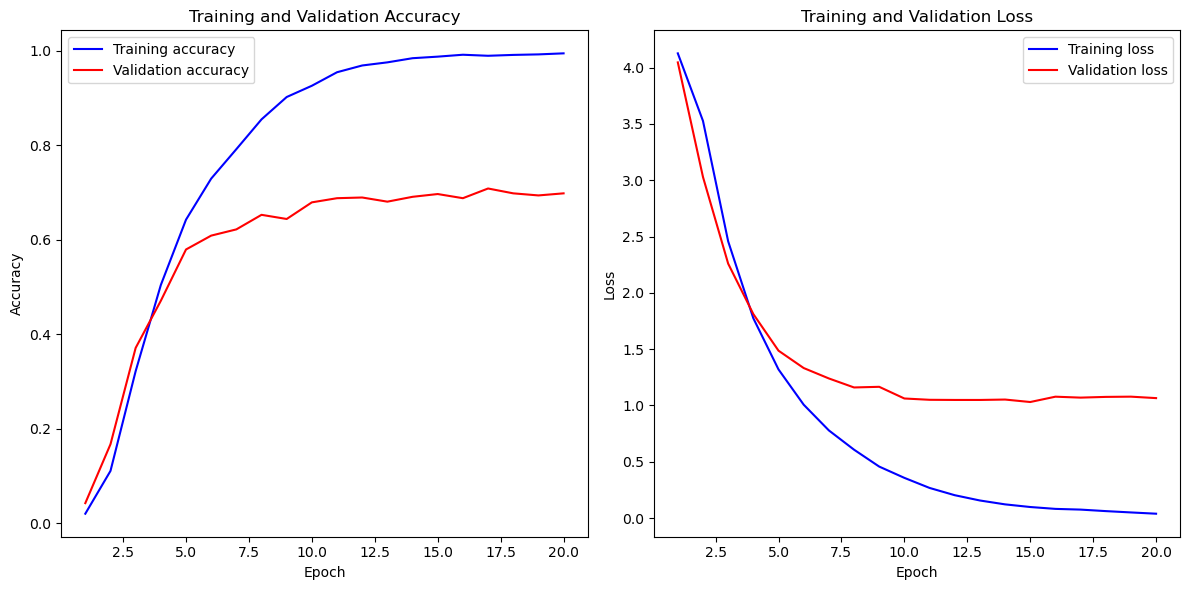

In [ ]:
plot_loss_and_accuracy_curves(history)

22/22 [==============================] - 1s 61ms/step
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        14
           1       0.50      0.73      0.59        11
           2       0.67      0.60      0.63        10
           3       0.69      0.55      0.61        20
           4       0.85      0.79      0.81        14
           5       0.71      0.62      0.67        16
           6       0.88      0.78      0.82         9
           7       0.86      0.80      0.83        15
           8       0.83      0.83      0.83        12
           9       0.53      0.82      0.64        11
           A       0.87      0.81      0.84        16
           B       0.88      0.78      0.82         9
           C       0.42      0.56      0.48         9
           D       0.91      1.00      0.95        10
           E       0.77      0.67      0.71        15
           F       1.00      0.93      0.96        14
           G       0.82    

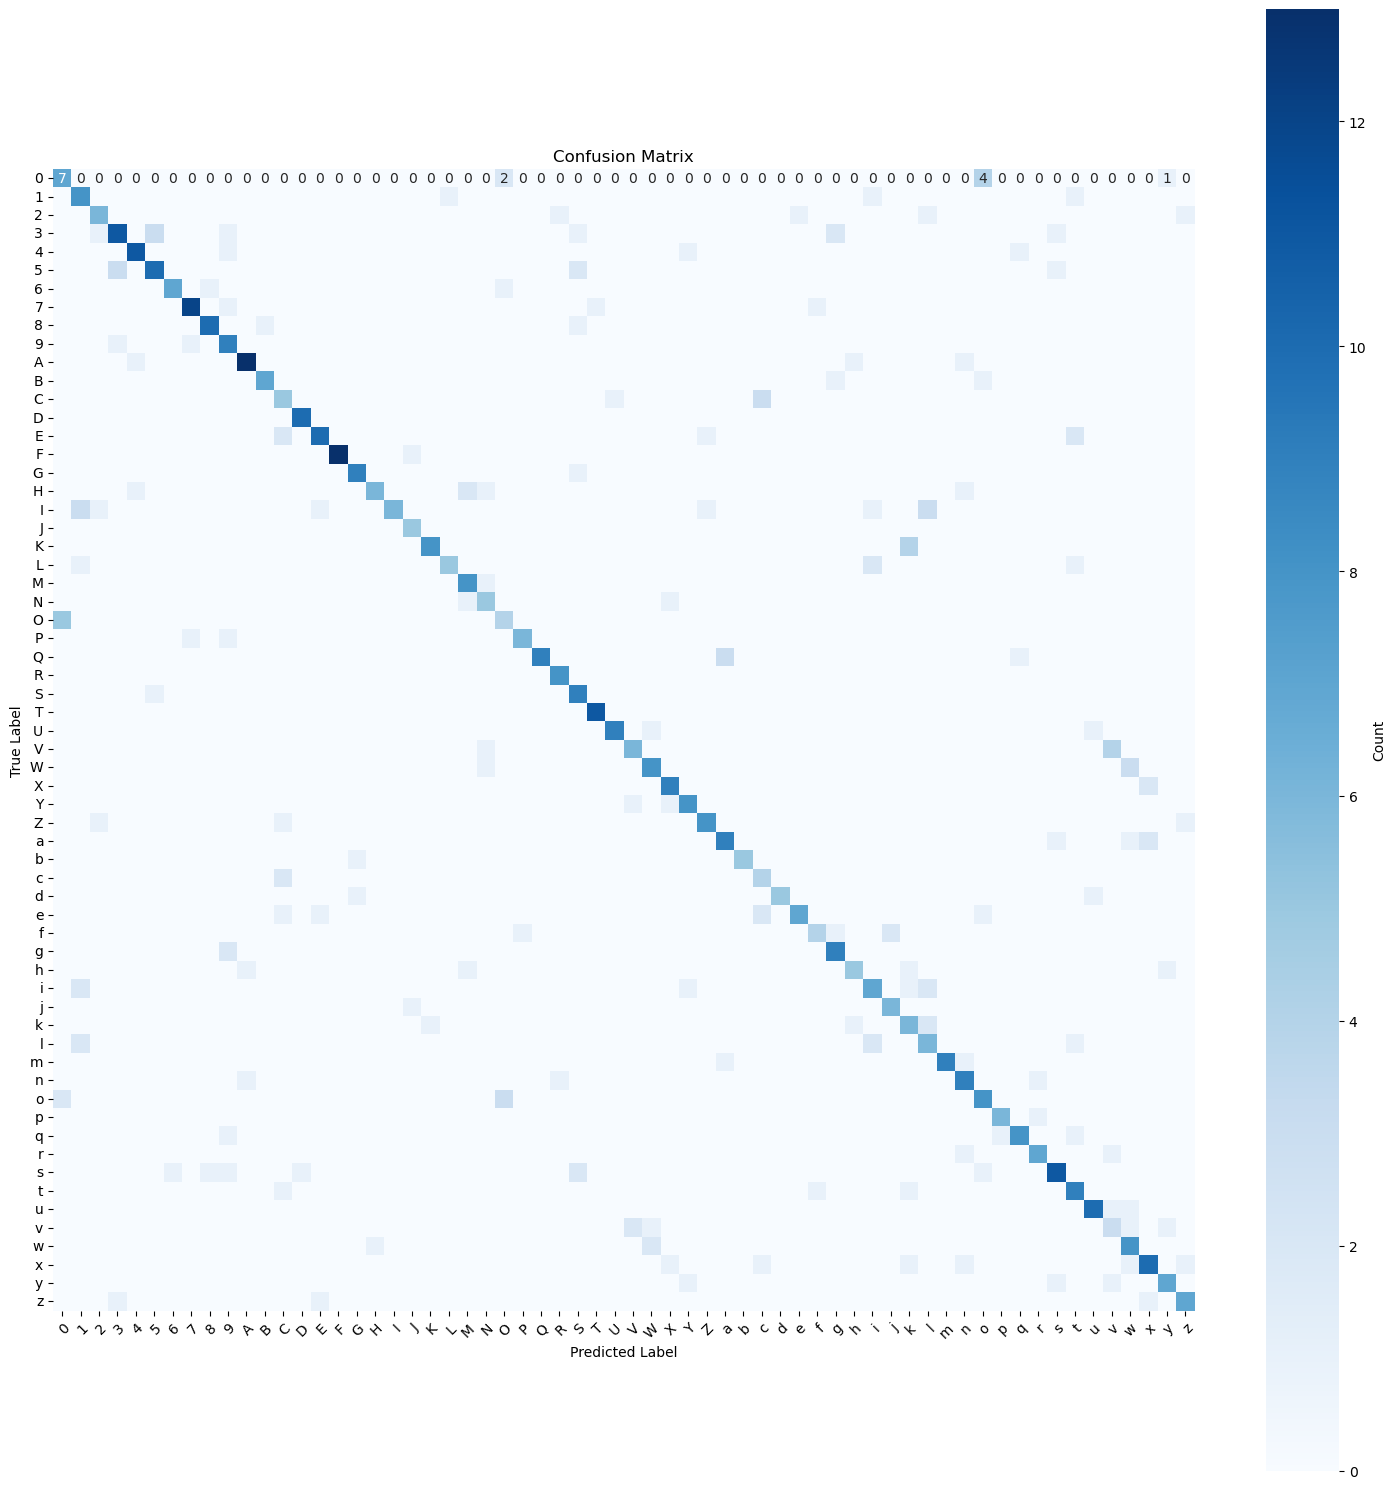

In [ ]:
y_pred_encoded = model.predict(X_test)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc* 100:.2f}%')

22/22 [==============================] - 1s 58ms/step - loss: 1.0308 - accuracy: 0.6965
Test Loss: 1.0308376550674438
Test Accuracy: 69.65%


Basic CNN Model With ImageDataGenerator

In [18]:
# Define the image data generator
datagen = ImageDataGenerator(
         width_shift_range=0.01, # horizontal shift
         height_shift_range=0.01, # vertical shift
         shear_range=0.1, # shear transformation
         zoom_range=0.1, # zoom
)
# Apply the data generator to the training and test sets
train_generator = datagen.flow(X_train, y_train_encoded, batch_size=32)
test_generator = datagen.flow(X_test, y_test_encoded, batch_size=32, shuffle=False)

In [ ]:
# Train the model using the data generators
history_imageGen = model.fit(
    train_generator,  # Use the train_generator for training data
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    epochs=50,
    validation_data=test_generator,  # Use the test_generator for validation data
    callbacks=[early_stopping, reduce_lr]  # Include both callbacks in the list
)

Epoch 1/50
85/85 [==============================] - 22s 262ms/step - loss: 0.1908 - accuracy: 0.9636 - val_loss: 1.0688 - val_accuracy: 0.7023 - lr: 1.0000e-04
Epoch 2/50
85/85 [==============================] - 23s 266ms/step - loss: 0.1873 - accuracy: 0.9614 - val_loss: 1.0135 - val_accuracy: 0.7038 - lr: 1.0000e-04
Epoch 3/50
85/85 [==============================] - 23s 274ms/step - loss: 0.1892 - accuracy: 0.9618 - val_loss: 0.9824 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 4/50
85/85 [==============================] - 25s 291ms/step - loss: 0.1746 - accuracy: 0.9674 - val_loss: 0.9946 - val_accuracy: 0.7155 - lr: 1.0000e-04
Epoch 5/50
85/85 [==============================] - 24s 278ms/step - loss: 0.1659 - accuracy: 0.9688 - val_loss: 0.9990 - val_accuracy: 0.7185 - lr: 1.0000e-04
Epoch 6/50
85/85 [==============================] - 23s 275ms/step - loss: 0.1590 - accuracy: 0.9703 - val_loss: 0.9813 - val_accuracy: 0.7023 - lr: 1.0000e-04
Epoch 7/50
85/85 [======================

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc* 100:.2f}%')

22/22 [==============================] - 2s 92ms/step - loss: 0.9918 - accuracy: 0.7141
Test Loss: 0.9917590618133545
Test Accuracy: 71.41%


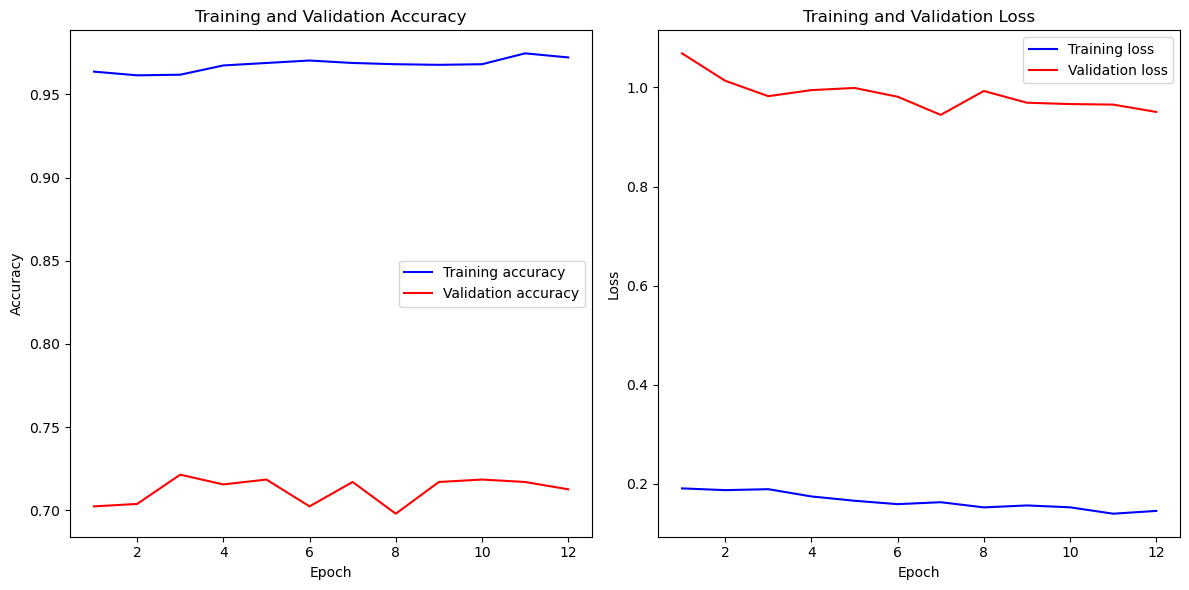

22/22 [==============================] - 3s 116ms/step
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        14
           1       0.43      0.55      0.48        11
           2       0.73      0.80      0.76        10
           3       0.67      0.60      0.63        20
           4       0.86      0.86      0.86        14
           5       0.65      0.81      0.72        16
           6       0.70      0.78      0.74         9
           7       1.00      0.73      0.85        15
           8       0.91      0.83      0.87        12
           9       0.56      0.82      0.67        11
           A       0.93      0.81      0.87        16
           B       0.78      0.78      0.78         9
           C       0.56      0.56      0.56         9
           D       0.82      0.90      0.86        10
           E       0.85      0.73      0.79        15
           F       1.00      0.93      0.96        14
           G       0.82   

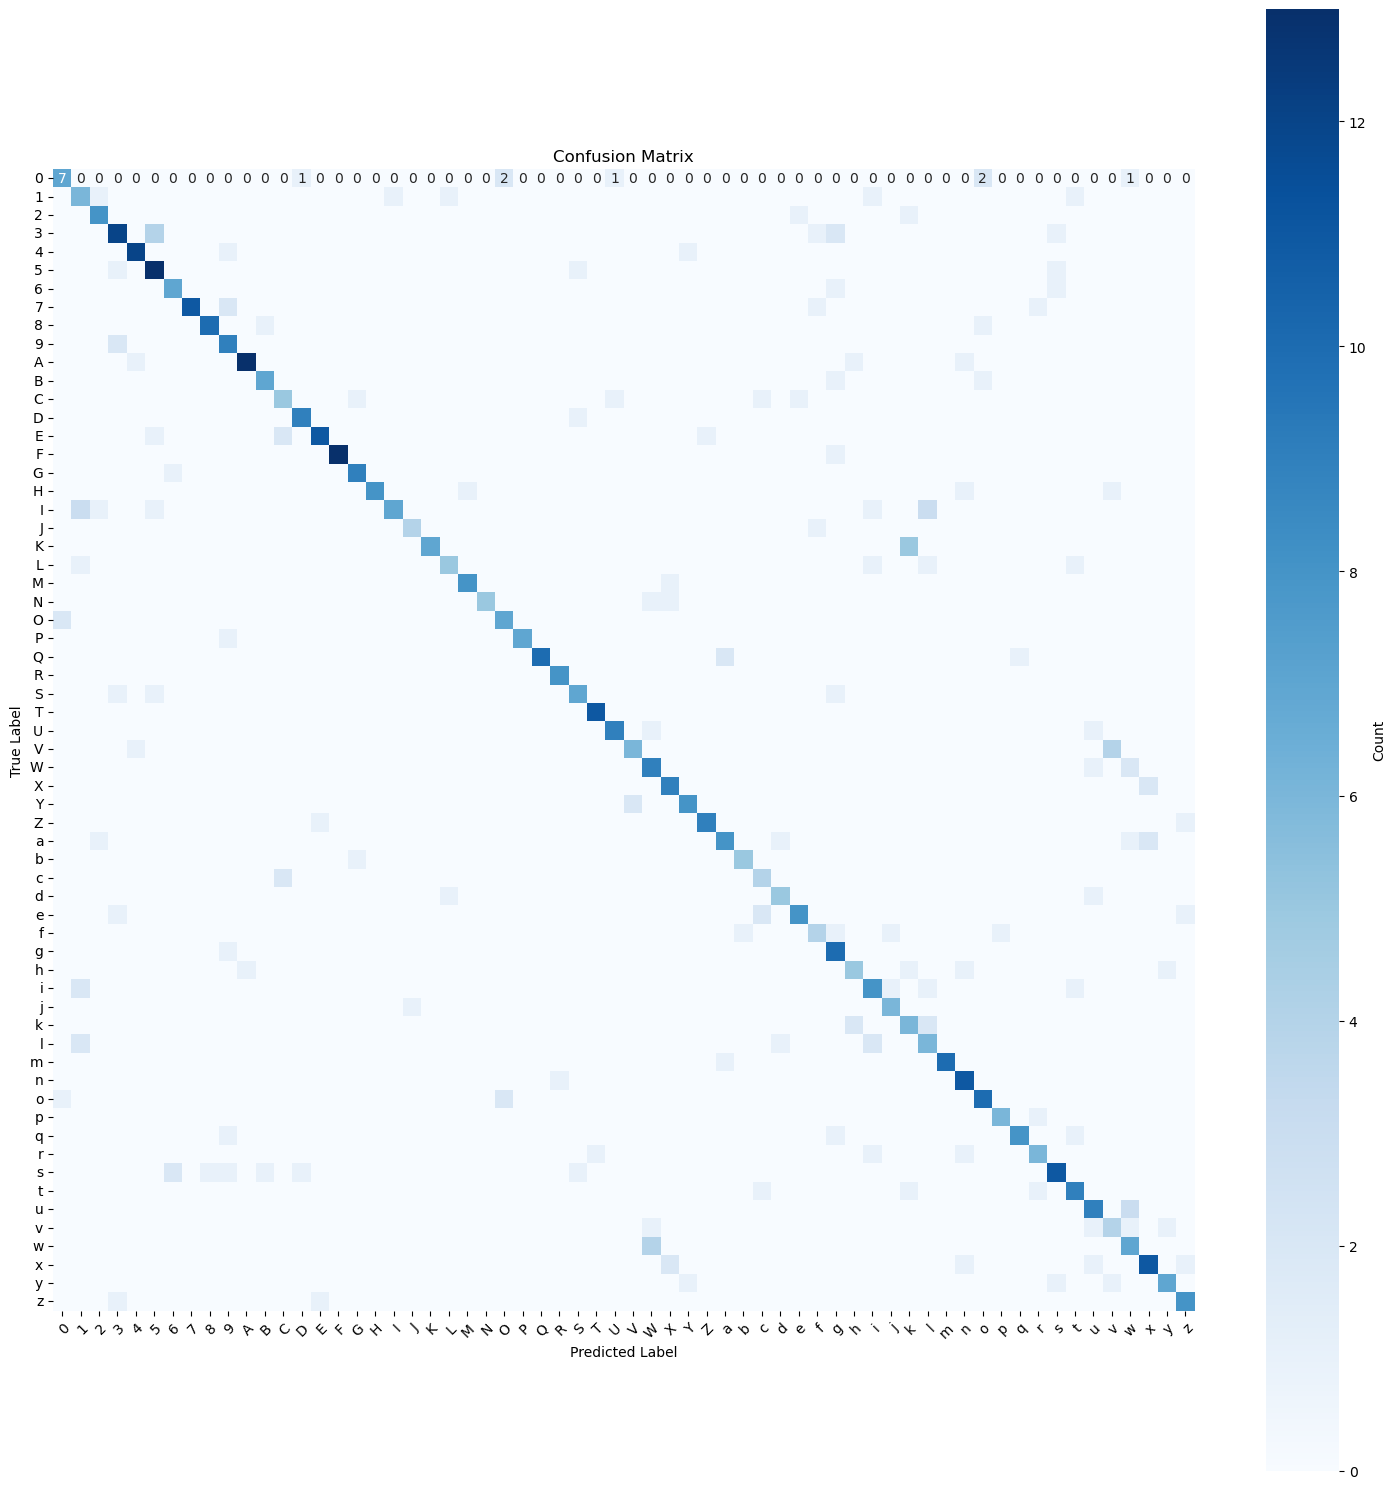

In [ ]:
plot_loss_and_accuracy_curves(history_imageGen)
y_pred_encoded = model.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

Model with Regularization

In [ ]:
# Define a model with l2 regularization
def build_icr_model_with_regu(input_shape, num_classes, dropout_rate=0.5, l2_rate=0.001):
    # Input layer
    input_img = Input(shape=input_shape, name='image_input')

    # CNN layers with L2 Regularization
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(input_img)
    # Add a MaxPooling layer
    x = MaxPooling2D((2, 2))(x)
    # Add a Conv2D layer with L2 Regularization
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    # Add a MaxPooling layer
    x = MaxPooling2D((2, 2))(x)
    # Add a Conv2D layer with L2 Regularization
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    # Add a MaxPooling layer
    x = MaxPooling2D((2, 2))(x)

    # Add a Dropout layer after Convolutional layers
    x = Dropout(dropout_rate)(x)

    # Reshape output for RNN input
    conv_shape = x.get_shape().as_list()  # [batch_size, height, width, channels]
    new_shape = (conv_shape[1], conv_shape[2] * conv_shape[3])  # Combine width and channels
    x = Reshape(target_shape=new_shape)(x)

    # RNN layers with GRU
    x = GRU(128, return_sequences=False)(x)

    # Add a Dropout layer after GRU layer
    x = Dropout(dropout_rate)(x)

    # Fully connected layer with L2 Regularization
    output = Dense(num_classes, activation='softmax', name='output', kernel_regularizer=l2(l2_rate))(x)

    # Define the model
    model = Model(inputs=input_img, outputs=output)
    # return the model
    return model

# Define the input shape and number of classes
input_shape = (128, 128, 3)  
num_classes = 62  

# Build the model with regularization
model = build_icr_model_with_regu(input_shape, num_classes)

# Compile the model with the loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define the early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model with regularization
history_regu = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
85/85 [==============================] - 33s 373ms/step - loss: 4.2770 - accuracy: 0.0156 - val_loss: 4.2382 - val_accuracy: 0.0176 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 30s 354ms/step - loss: 4.1490 - accuracy: 0.0300 - val_loss: 3.9607 - val_accuracy: 0.0704 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 31s 364ms/step - loss: 3.7364 - accuracy: 0.0772 - val_loss: 3.5385 - val_accuracy: 0.1202 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 30s 356ms/step - loss: 3.3316 - accuracy: 0.1324 - val_loss: 3.1641 - val_accuracy: 0.1745 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 30s 351ms/step - loss: 3.0157 - accuracy: 0.1895 - val_loss: 2.8336 - val_accuracy: 0.2317 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 31s 371ms/step - loss: 2.6516 - accuracy: 0.2726 - val_loss: 2.4283 - val_accuracy: 0.3666 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 31s 366ms/st

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc* 100:.2f}%')

22/22 [==============================] - 2s 86ms/step - loss: 0.8264 - accuracy: 0.8021
Test Loss: 0.8263633251190186
Test Accuracy: 80.21%


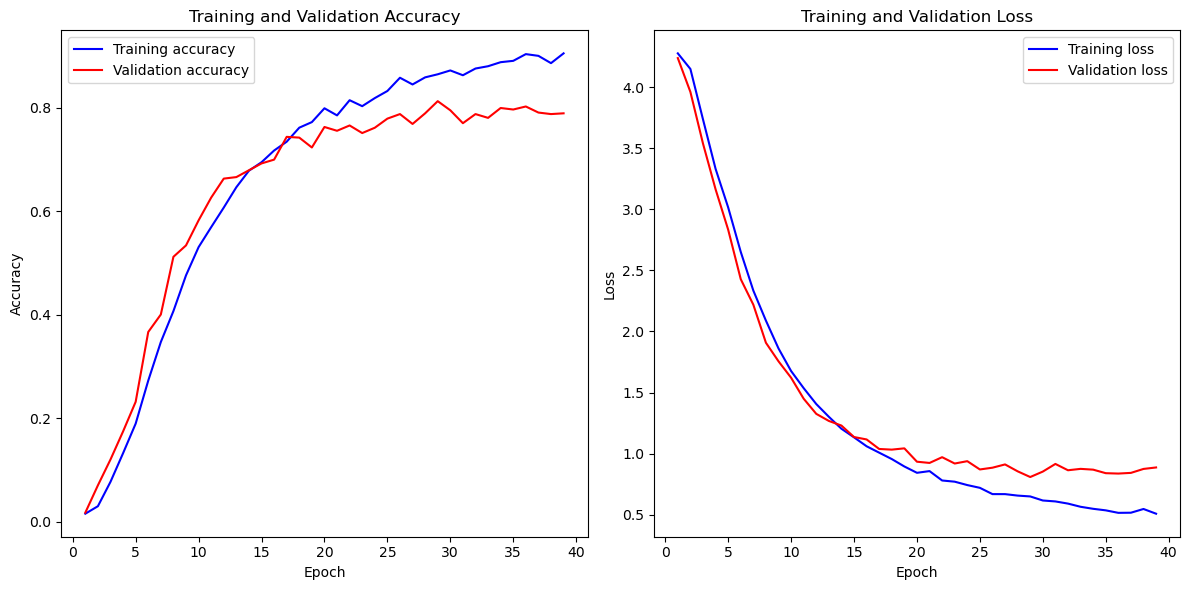

22/22 [==============================] - 3s 87ms/step
              precision    recall  f1-score   support

           0       0.56      0.36      0.43        14
           1       0.57      0.36      0.44        11
           2       1.00      1.00      1.00        10
           3       0.79      0.75      0.77        20
           4       1.00      0.86      0.92        14
           5       1.00      0.88      0.93        16
           6       0.75      0.67      0.71         9
           7       0.92      0.80      0.86        15
           8       0.53      0.75      0.62        12
           9       0.91      0.91      0.91        11
           A       0.88      0.94      0.91        16
           B       0.80      0.89      0.84         9
           C       0.86      0.67      0.75         9
           D       1.00      1.00      1.00        10
           E       0.93      0.93      0.93        15
           F       0.93      0.93      0.93        14
           G       0.91    

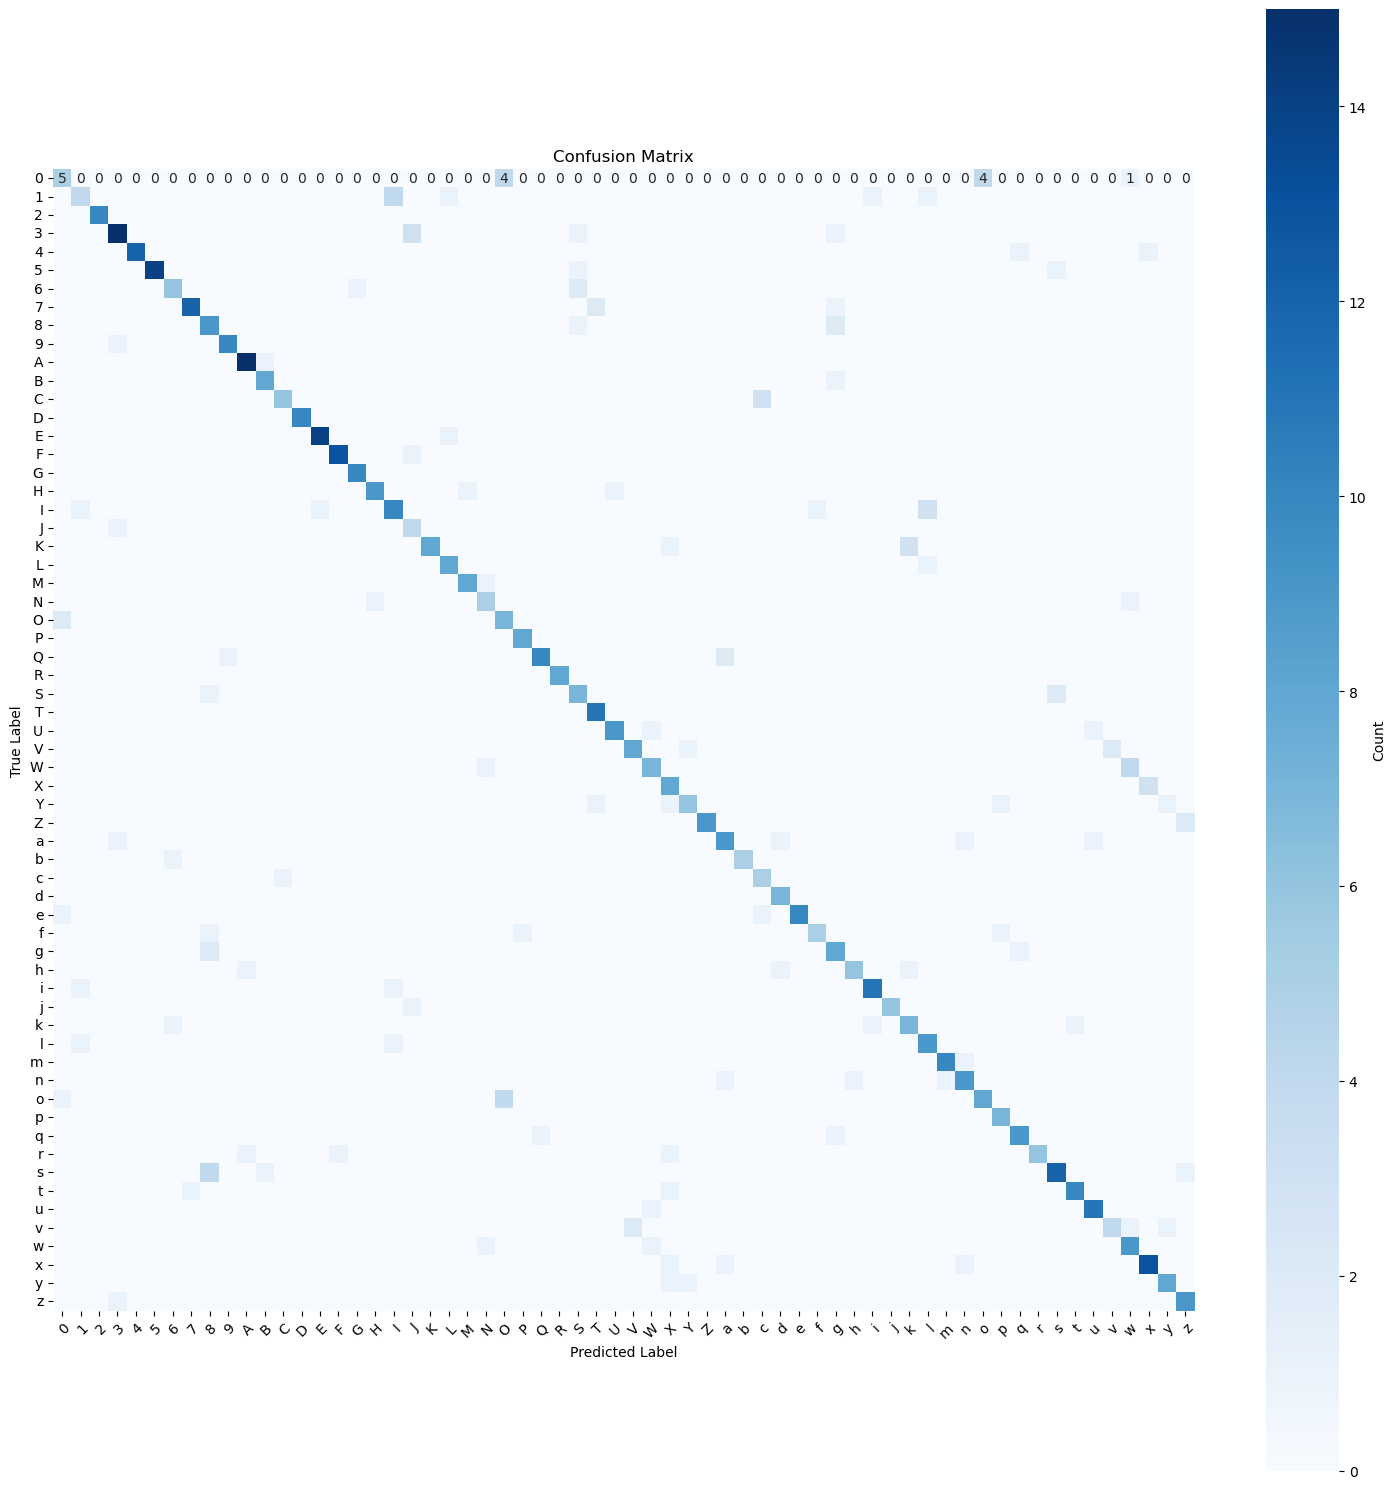

In [ ]:
# Plot the loss and accuracy curves and confusion matrix
plot_loss_and_accuracy_curves(history_regu)
y_pred_encoded = model.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [ ]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_regu')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_regu/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_regu/assets


Hyperparameters Tuner Model

Step 1: Define a HyperModel Class

In [ ]:
# Define the hypermodel class
class ICRHyperModel(HyperModel):
    # Initialize the class with input shape and number of classes
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    # Define the build method
    def build(self, hp):
        input_img = Input(shape=self.input_shape, name='image_input')
        x = input_img

        # Define convolutional layers
        for i in range(hp.Int('num_conv_layers', min_value=1, max_value=5)):
            filters = hp.Int(f'conv_{i}_filters', min_value=32, max_value=256, step=32)
            kernel_size = hp.Int(f'conv_{i}_kernel', min_value=3, max_value=7)
            x = Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same')(x)
            x = MaxPooling2D((2, 2))(x)

        # Reshape output for RNN input
        conv_shape = x.get_shape().as_list()  # [batch_size, height, width, channels]
        new_shape = (-1, conv_shape[2] * conv_shape[3])  # Combine width and channels
        x = Reshape(target_shape=new_shape)(x)

        # RNN layers with GRU - tunable number of units
        x = GRU(hp.Int('gru_units', min_value=64, max_value=256, step=64), return_sequences=False)(x)

        # Fully connected layer
        output = Dense(self.num_classes, activation='softmax', name='output')(x)

        # Define the model
        model = Model(inputs=input_img, outputs=output)
        # Compile the model with a tunable learning rate
        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        # Return the model
        return model

Step 2: Initialize the HyperModel and Tuner

In [ ]:
# Define the input shape and the number of classes
input_shape = (128, 128, 3)
num_classes = 62

# Initialize your HyperModel with the required arguments
hypermodel = ICRHyperModel(input_shape=input_shape, num_classes=num_classes)

# Initialize the tuner
tuner = RandomSearch(
    hypermodel=hypermodel,
    objective='val_accuracy',
    max_trials=15,
    directory='model_tuning',
    project_name='english_tuning'
)

Reloading Tuner from model_tuning/english_tuning/tuner0.json


/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_44032/1056909561.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Step 3: Start the Tuning Process

In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# tuner.search() use the generators
tuner.search(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=35,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the best hyperparameters
best_model1 = hypermodel.build(best_hps)

In [ ]:
best_model1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_58 (Conv2D)          (None, 128, 128, 224)     33152     
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 64, 64, 224)       0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 64, 64, 128)       458880    
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                                           
                                                                 
 reshape_14 (Reshape)        (None, 32, 4096)          0   

In [ ]:
# Train the model with the best hyperparameters
history = best_model1.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
85/85 [==============================] - 179s 2s/step - loss: 4.1265 - accuracy: 0.0182 - val_loss: 4.0073 - val_accuracy: 0.0455 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 196s 2s/step - loss: 3.3597 - accuracy: 0.1142 - val_loss: 2.7864 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 184s 2s/step - loss: 2.1693 - accuracy: 0.3709 - val_loss: 1.8904 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 189s 2s/step - loss: 1.4134 - accuracy: 0.5805 - val_loss: 1.4488 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 159s 2s/step - loss: 0.9773 - accuracy: 0.7070 - val_loss: 1.2309 - val_accuracy: 0.6246 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 168s 2s/step - loss: 0.6797 - accuracy: 0.7960 - val_loss: 1.0334 - val_accuracy: 0.6994 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 169s 2s/step - loss: 0.5

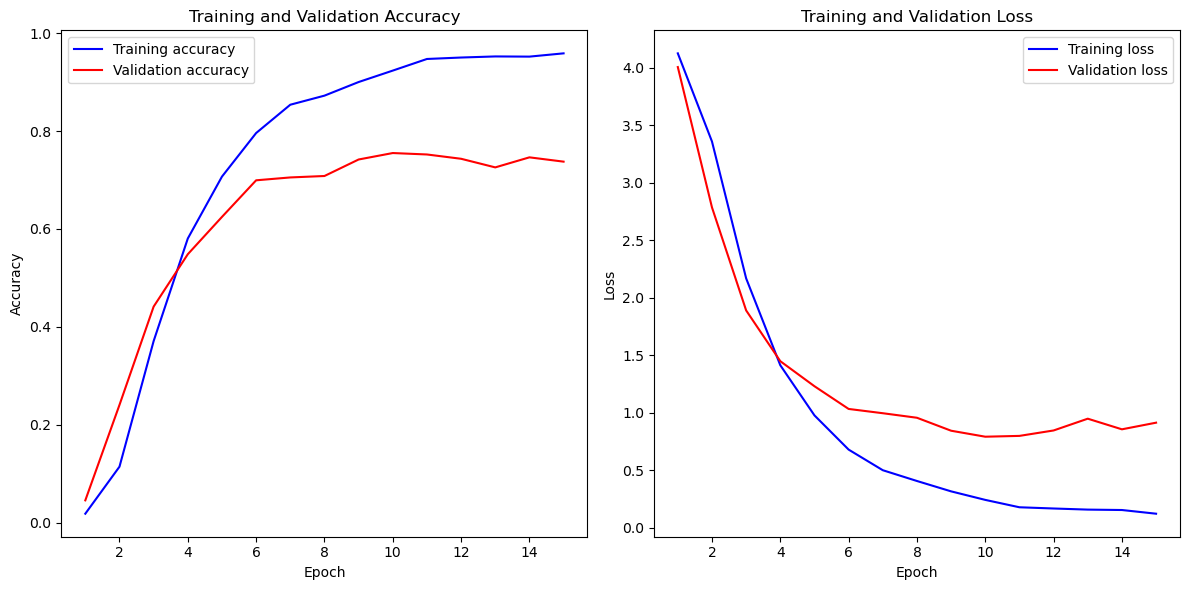

22/22 [==============================] - 11s 493ms/step
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        14
           1       0.70      0.64      0.67        11
           2       0.80      0.80      0.80        10
           3       0.76      0.65      0.70        20
           4       0.93      0.93      0.93        14
           5       0.87      0.81      0.84        16
           6       0.88      0.78      0.82         9
           7       0.92      0.73      0.81        15
           8       0.78      0.58      0.67        12
           9       0.88      0.64      0.74        11
           A       0.94      0.94      0.94        16
           B       0.88      0.78      0.82         9
           C       0.83      0.56      0.67         9
           D       0.90      0.90      0.90        10
           E       0.93      0.93      0.93        15
           F       0.81      0.93      0.87        14
           G       1.00  

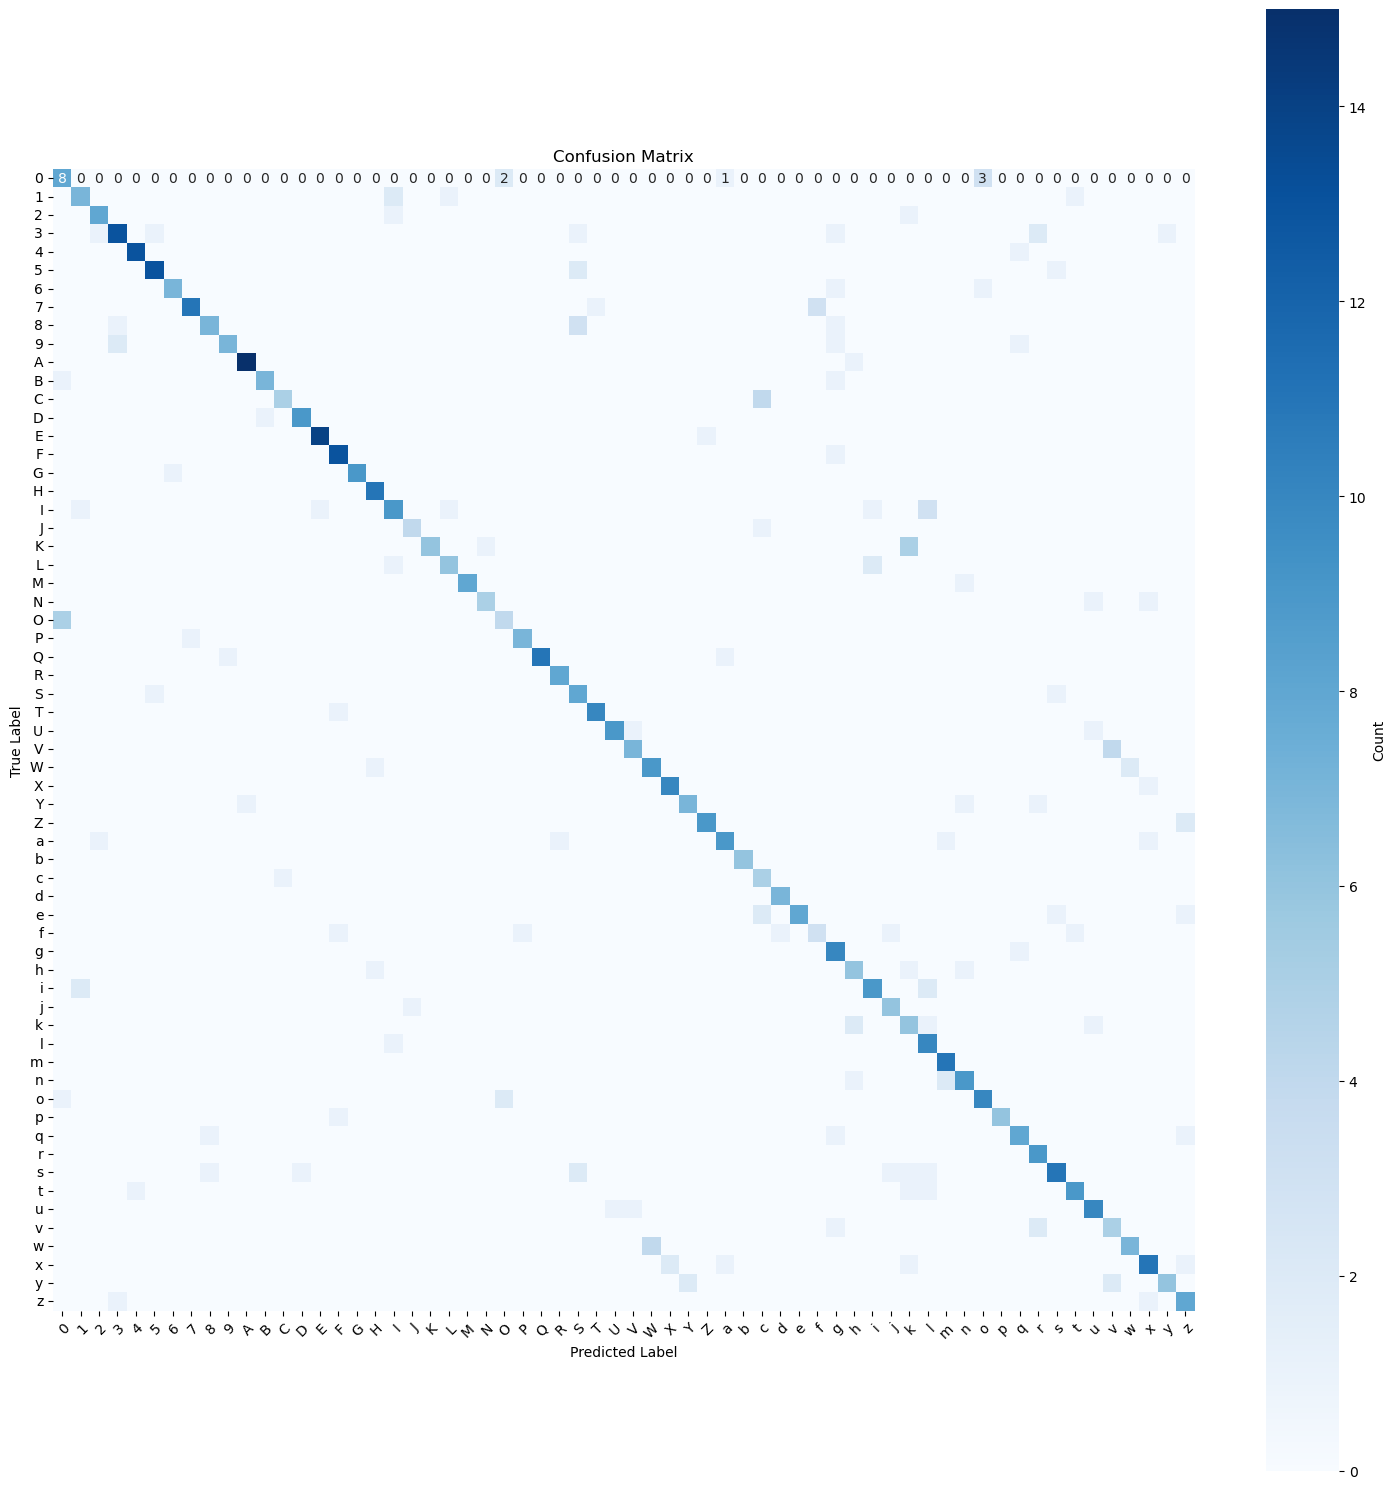

In [ ]:
# Plot the loss and accuracy curves and confusion matrix
plot_loss_and_accuracy_curves(history)
y_pred_encoded = best_model1.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [ ]:
# Evaluate the model
test_loss, test_acc = best_model1.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

22/22 [==============================] - 10s 474ms/step - loss: 0.8085 - accuracy: 0.7522
Test Loss: 0.8085266351699829
Test Accuracy: 75.22%


HyperModel with Regularization

In [169]:
# Define a hyperparameter model
class ICRHyperModel_regu(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        # Start model definition
        input_img = Input(shape=self.input_shape, name='image_input')
        
        # CNN layers with tunable hyperparameters
        x = input_img
        for i in range(hp.Int('num_conv_layers', min_value=1, max_value=5)):
            x = Conv2D(
                filters=hp.Choice(f'conv_{i}_filters', [32, 64, 128]),
                kernel_size=hp.Choice(f'conv_{i}_kernel_size', [3, 5]),
                activation='relu',
                padding='same',
                kernel_regularizer=l2(hp.Float('conv_l2_rate', 1e-5, 1e-2, sampling='log'))
            )(x)
            x = MaxPooling2D((2, 2))(x)
            x = Dropout(rate=hp.Float(f'conv_{i}_dropout_rate', 0.2, 0.5))(x)

        # Reshape for RNN input
        conv_shape = x.get_shape().as_list()
        new_shape = (conv_shape[1], conv_shape[2] * conv_shape[3])
        x = Reshape(target_shape=new_shape)(x)

        # RNN layer with GRU
        x = GRU(
            units=hp.Int('gru_units', 64, 256, step=32),
            return_sequences=False,
            kernel_regularizer=l2(hp.Float('gru_l2_rate', 1e-5, 1e-2, sampling='log'))
        )(x)
        x = Dropout(rate=hp.Float('gru_dropout_rate', 0.2, 0.5))(x)

        # Fully connected layer
        x = Dense(
            units=hp.Int('dense_units', 64, 256, step=32),
            activation='relu',
            kernel_regularizer=l2(hp.Float('dense_l2_rate', 1e-5, 1e-2, sampling='log'))
        )(x)
        x = Dropout(rate=hp.Float('dense_dropout_rate', 0.2, 0.5))(x)

        # Output layer
        output = Dense(self.num_classes, activation='softmax', name='output')(x)

        # Define the model
        model = Model(inputs=input_img, outputs=output)

        # Compile the model
        model.compile(
            optimizer=Adam(
                hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

In [170]:
# Instantiate the hypermodel
input_shape = (128, 128, 3)
num_classes = 62
hypermodel = ICRHyperModel_regu(input_shape, num_classes)

# Run a random search
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=25,
    directory='model_tuning',
    project_name='english_tuning_with_regu'
)

Reloading Tuner from model_tuning/english_tuning_with_regu/tuner0.json


In [171]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Modify the tuner.search() to use the generators
tuner.search(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)

In [172]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the best hyperparameters
best_model2 = hypermodel.build(best_hps)

In [173]:
best_model2.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_102 (Conv2D)         (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_102 (MaxPool  (None, 64, 64, 128)       0         
 ing2D)                                                          
                                                                 
 dropout_38 (Dropout)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_103 (Conv2D)         (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_103 (MaxPool  (None, 32, 32, 128)       0         
 ing2D)                                                   

In [174]:
# Train the model with the best hyperparameters
history = best_model2.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
85/85 [==============================] - 100s 1s/step - loss: 4.9048 - accuracy: 0.0129 - val_loss: 4.8554 - val_accuracy: 0.0132 - lr: 1.2784e-04
Epoch 2/50
85/85 [==============================] - 75s 878ms/step - loss: 4.8160 - accuracy: 0.0193 - val_loss: 4.7761 - val_accuracy: 0.0147 - lr: 1.2784e-04
Epoch 3/50
85/85 [==============================] - 76s 895ms/step - loss: 4.7399 - accuracy: 0.0171 - val_loss: 4.7052 - val_accuracy: 0.0132 - lr: 1.2784e-04
Epoch 4/50
85/85 [==============================] - 75s 881ms/step - loss: 4.6729 - accuracy: 0.0178 - val_loss: 4.6426 - val_accuracy: 0.0132 - lr: 1.2784e-04
Epoch 5/50
85/85 [==============================] - 80s 936ms/step - loss: 4.6135 - accuracy: 0.0159 - val_loss: 4.5881 - val_accuracy: 0.0103 - lr: 1.2784e-04
Epoch 6/50
85/85 [==============================] - 89s 1s/step - loss: 4.5625 - accuracy: 0.0130 - val_loss: 4.5399 - val_accuracy: 0.0117 - lr: 1.2784e-04
Epoch 7/50
85/85 [===========================

In [178]:
# Evaluate the model
test_loss, test_acc = best_model2.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

22/22 [==============================] - 5s 228ms/step - loss: 0.9740 - accuracy: 0.7815
Test Loss: 0.9740102887153625
Test Accuracy: 78.15%


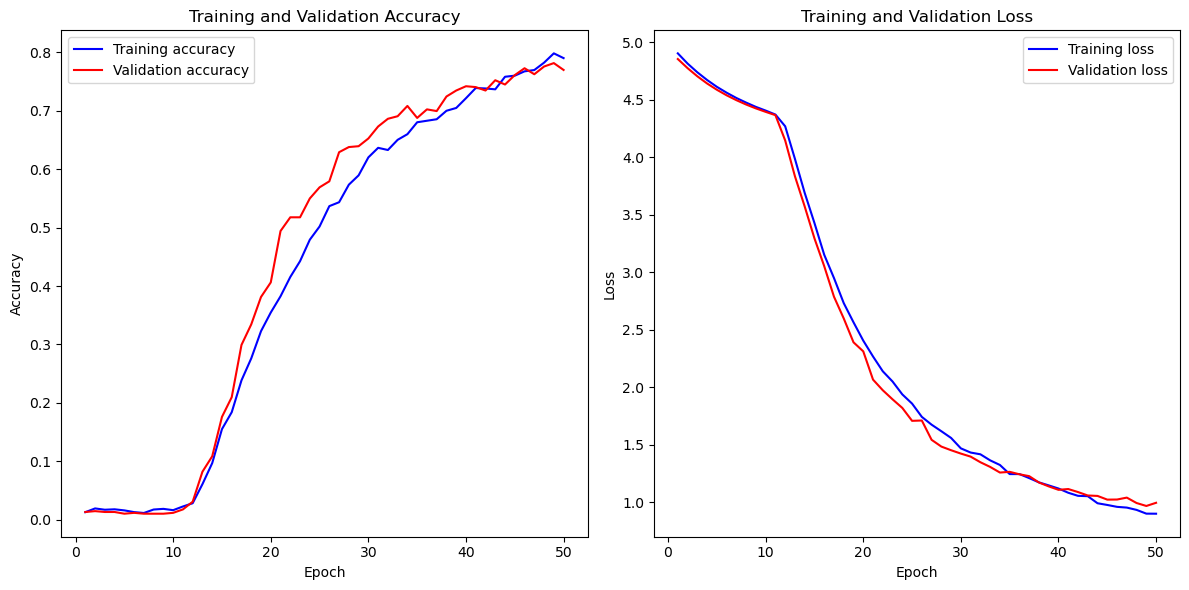

22/22 [==============================] - 6s 208ms/step
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.43      0.82      0.56        11
           2       0.80      0.80      0.80        10
           3       0.76      0.95      0.84        20
           4       0.92      0.86      0.89        14
           5       0.74      0.88      0.80        16
           6       0.73      0.89      0.80         9
           7       0.82      0.93      0.87        15
           8       0.75      0.75      0.75        12
           9       0.69      0.82      0.75        11
           A       0.93      0.88      0.90        16
           B       0.78      0.78      0.78         9
           C       0.50      0.89      0.64         9
           D       1.00      1.00      1.00        10
           E       1.00      1.00      1.00        15
           F       0.93      0.93      0.93        14
           G       1.00   

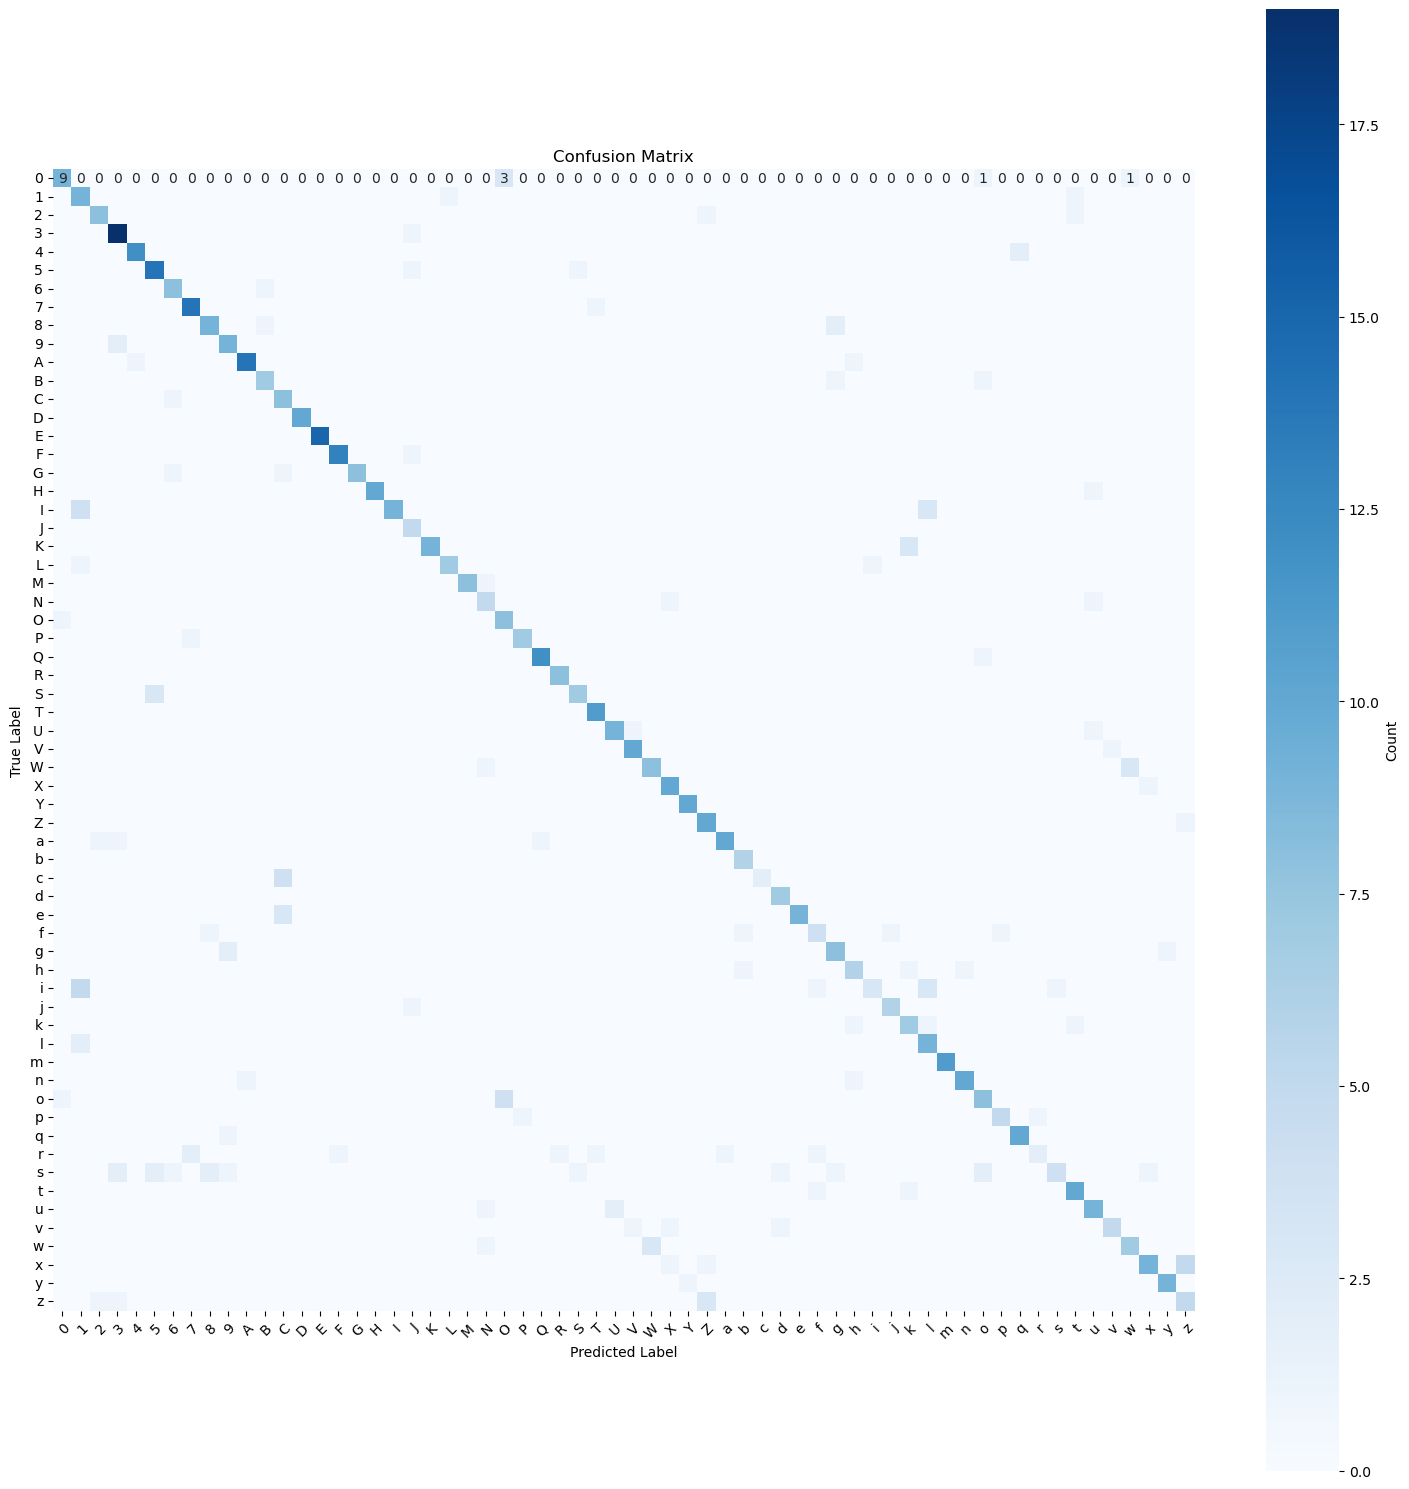

In [179]:
plot_loss_and_accuracy_curves(history)
y_pred_encoded = best_model2.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [181]:
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_hyper_with_regu')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_hyper_with_regu/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_hyper_with_regu/assets


HyperModel2

In [161]:
# Define the hypermodel class
class ICRHyperModel2(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        input_img = Input(shape=self.input_shape, name='image_input')
        x = input_img

        # Define convolutional layers
        for i in range(hp.Int('num_conv_layers', min_value=1, max_value=5)):
            filters = hp.Int(f'conv_{i}_filters', min_value=32, max_value=256, step=32)
            kernel_size = hp.Int(f'conv_{i}_kernel', min_value=3, max_value=7)
            x = Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same')(x)
            x = MaxPooling2D((2, 2))(x)

        # Flatten the output of the convolutional layers to feed into the dense layer
        x = Flatten()(x)

        # Fully connected layer
        output = Dense(self.num_classes, activation='softmax', name='output')(x)

        # Define the model
        model = Model(inputs=input_img, outputs=output)
        # Compile the model with a tunable learning rate
        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [162]:
# Instantiate the hypermodel
input_shape = (128, 128, 3)
num_classes = 62
hypermodel = ICRHyperModel2(input_shape, num_classes)

# Run a random search
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=25,
    directory='model_tuning',
    project_name='english_tuning2'
)

Reloading Tuner from model_tuning/english_tuning2/tuner0.json


In [163]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Modify the tuner.search() to use the generators
tuner.search(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping]
)

In [164]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the best hyperparameters
best_model3 = hypermodel.build(best_hps)

In [165]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_model2')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_model2/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_model2/assets


In [166]:
# Train the model with the best hyperparameters
history = best_model3.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
85/85 [==============================] - 381s 4s/step - loss: 4.1290 - accuracy: 0.0219 - val_loss: 4.0936 - val_accuracy: 0.0367 - lr: 1.0000e-04
Epoch 2/50
85/85 [==============================] - 437s 5s/step - loss: 3.0794 - accuracy: 0.2441 - val_loss: 2.1842 - val_accuracy: 0.4208 - lr: 1.0000e-04
Epoch 3/50
85/85 [==============================] - 503s 6s/step - loss: 1.5311 - accuracy: 0.5924 - val_loss: 1.5601 - val_accuracy: 0.5982 - lr: 1.0000e-04
Epoch 4/50
85/85 [==============================] - 452s 5s/step - loss: 0.9717 - accuracy: 0.7322 - val_loss: 1.3574 - val_accuracy: 0.6628 - lr: 1.0000e-04
Epoch 5/50
85/85 [==============================] - 431s 5s/step - loss: 0.6909 - accuracy: 0.8079 - val_loss: 1.3165 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 6/50
85/85 [==============================] - 437s 5s/step - loss: 0.5002 - accuracy: 0.8568 - val_loss: 1.1800 - val_accuracy: 0.7258 - lr: 1.0000e-04
Epoch 7/50
85/85 [==============================] - 

In [167]:
# Evaluate the model
test_loss, test_acc = best_model3.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

22/22 [==============================] - 45s 2s/step - loss: 1.4034 - accuracy: 0.7581
Test Loss: 1.403409481048584
Test Accuracy: 75.81%


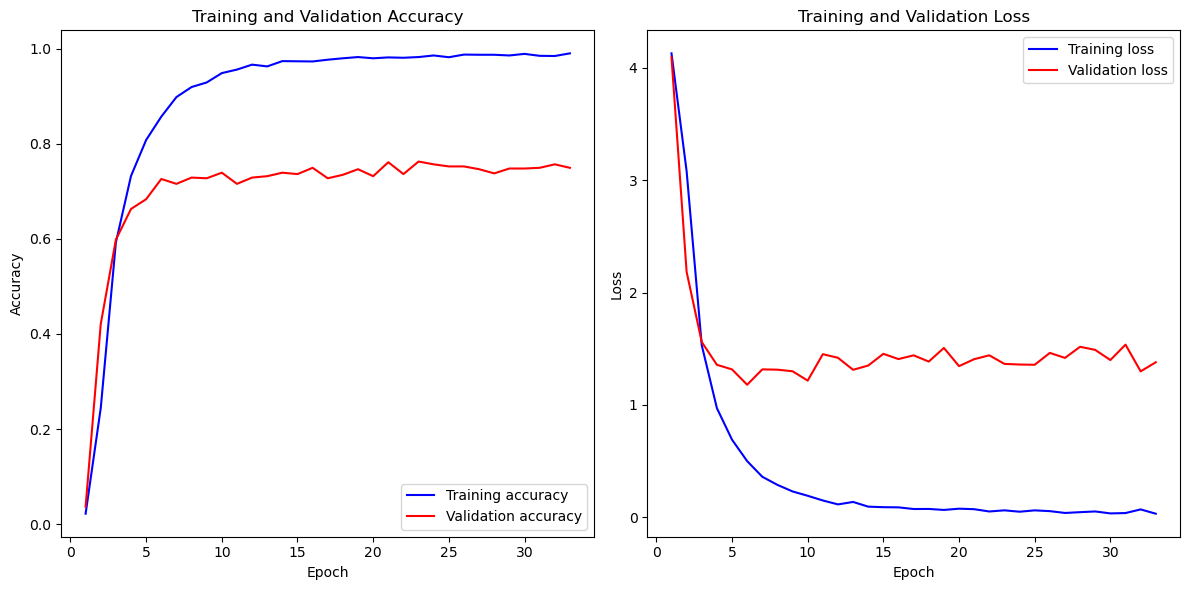

22/22 [==============================] - 37s 2s/step
              precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       0.36      0.36      0.36        11
           2       0.64      0.70      0.67        10
           3       0.79      0.75      0.77        20
           4       0.87      0.93      0.90        14
           5       0.80      0.75      0.77        16
           6       1.00      0.56      0.71         9
           7       0.87      0.87      0.87        15
           8       0.88      0.58      0.70        12
           9       0.73      0.73      0.73        11
           A       0.94      0.94      0.94        16
           B       0.73      0.89      0.80         9
           C       0.75      0.67      0.71         9
           D       0.91      1.00      0.95        10
           E       1.00      0.80      0.89        15
           F       0.87      0.93      0.90        14
           G       0.83     

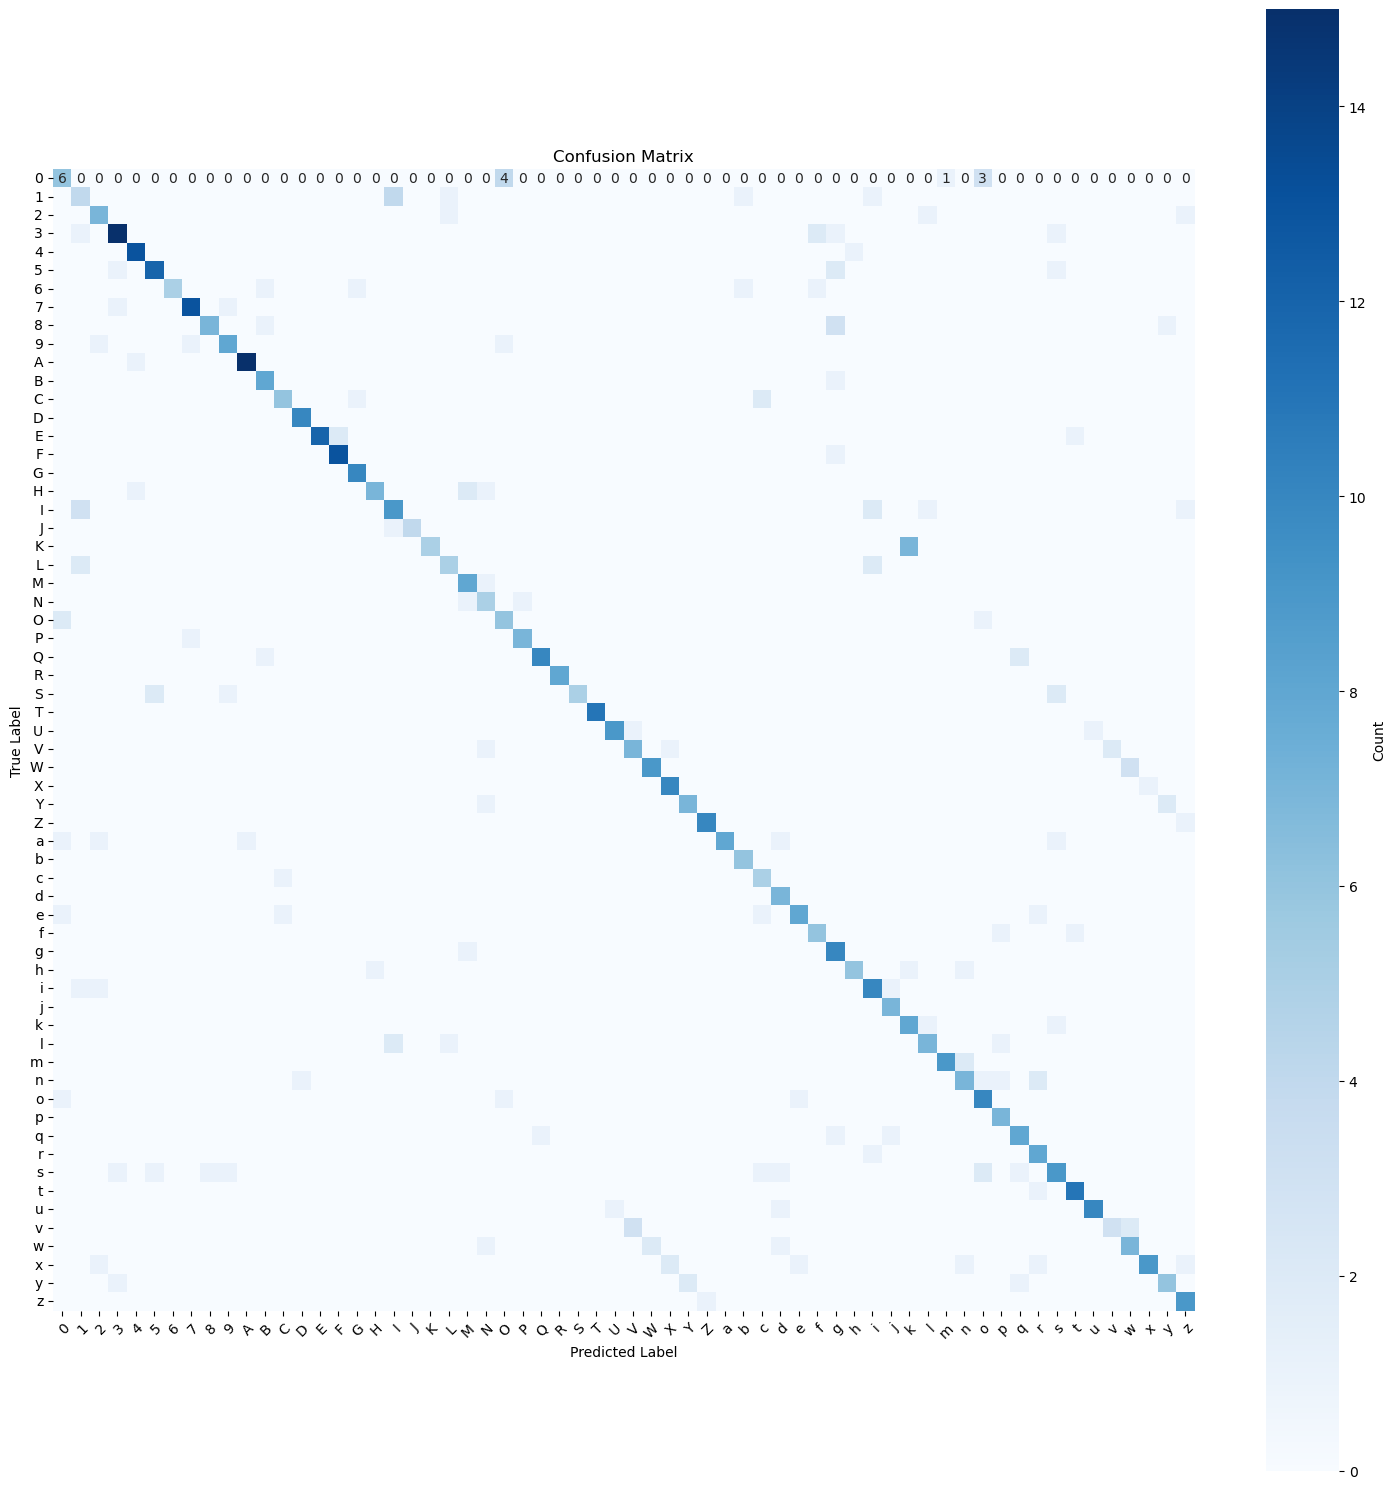

In [168]:
plot_loss_and_accuracy_curves(history)
y_pred_encoded = best_model3.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

CNN with LSTM

In [143]:
# Define the model with LSTM with 3 convolutional layers and L2 regularization
def build_icr_model_with_lstm(input_shape, num_classes, dropout_rate=0.5, l2_rate=0.001):
    input_img = Input(shape=input_shape, name='image_input')

    # CNN layers with L2 Regularization
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)

    # Optional: Add a Dropout layer after Convolutional layers
    x = Dropout(dropout_rate)(x)

    # Reshape output for RNN input
    conv_shape = x.get_shape().as_list()  # [batch_size, height, width, channels]
    new_shape = (conv_shape[1], conv_shape[2] * conv_shape[3])  # Combine width and channels for LSTM input
    x = Reshape(target_shape=new_shape)(x)

    # RNN layer with LSTM
    x = LSTM(128, return_sequences=False)(x)

    # Optional: Add a Dropout layer after LSTM layer
    x = Dropout(dropout_rate)(x)

    # Fully connected layer with L2 Regularization
    output = Dense(num_classes, activation='softmax', name='output', kernel_regularizer=l2(l2_rate))(x)

    # Define the model
    model = Model(inputs=input_img, outputs=output)
    
    return model

input_shape = (128, 128, 3)  # Assuming the input images are 128x128 RGB images
num_classes = 62  # Assuming 62 classes for the classification task

# Build the model with LSTM
model = build_icr_model_with_lstm(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [145]:
# Define the early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model with LSTM
history_lstm1 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100


85/85 [==============================] - 15s 180ms/step - loss: 0.9226 - accuracy: 0.7611 - val_loss: 1.0609 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 16s 183ms/step - loss: 0.8916 - accuracy: 0.7632 - val_loss: 1.0221 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 3/100
85/85 [==============================] - 15s 174ms/step - loss: 0.8566 - accuracy: 0.7800 - val_loss: 1.0189 - val_accuracy: 0.7390 - lr: 0.0010
Epoch 4/100
85/85 [==============================] - 15s 176ms/step - loss: 0.7834 - accuracy: 0.8079 - val_loss: 0.9359 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 5/100
85/85 [==============================] - 15s 178ms/step - loss: 0.7714 - accuracy: 0.8093 - val_loss: 1.0058 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 15s 174ms/step - loss: 0.7127 - accuracy: 0.8246 - val_loss: 0.9147 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - 16s 192ms/step - 

22/22 [==============================] - 1s 40ms/step - loss: 0.7866 - accuracy: 0.7933
Test Loss: 0.7865960597991943
Test Accuracy: 79.33%


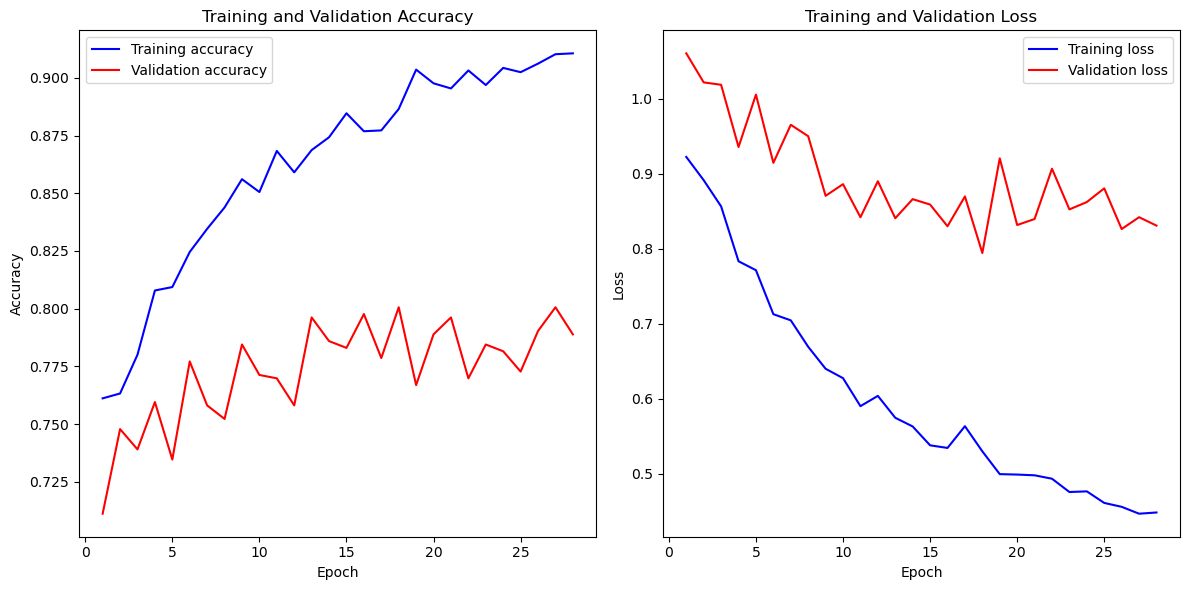

22/22 [==============================] - 4s 161ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        11
           A       0.00      0.00      0.00        16
           B       0.00      0.00      0.00         9
           C       0.00      0.00      0.00         9
           D       0.00      0.00      0.00        10
           E       0.00      0.00      0.00        15
           F       0.00      0.00      0.00        14
           G       0.00   

/Users/liqi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liqi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liqi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


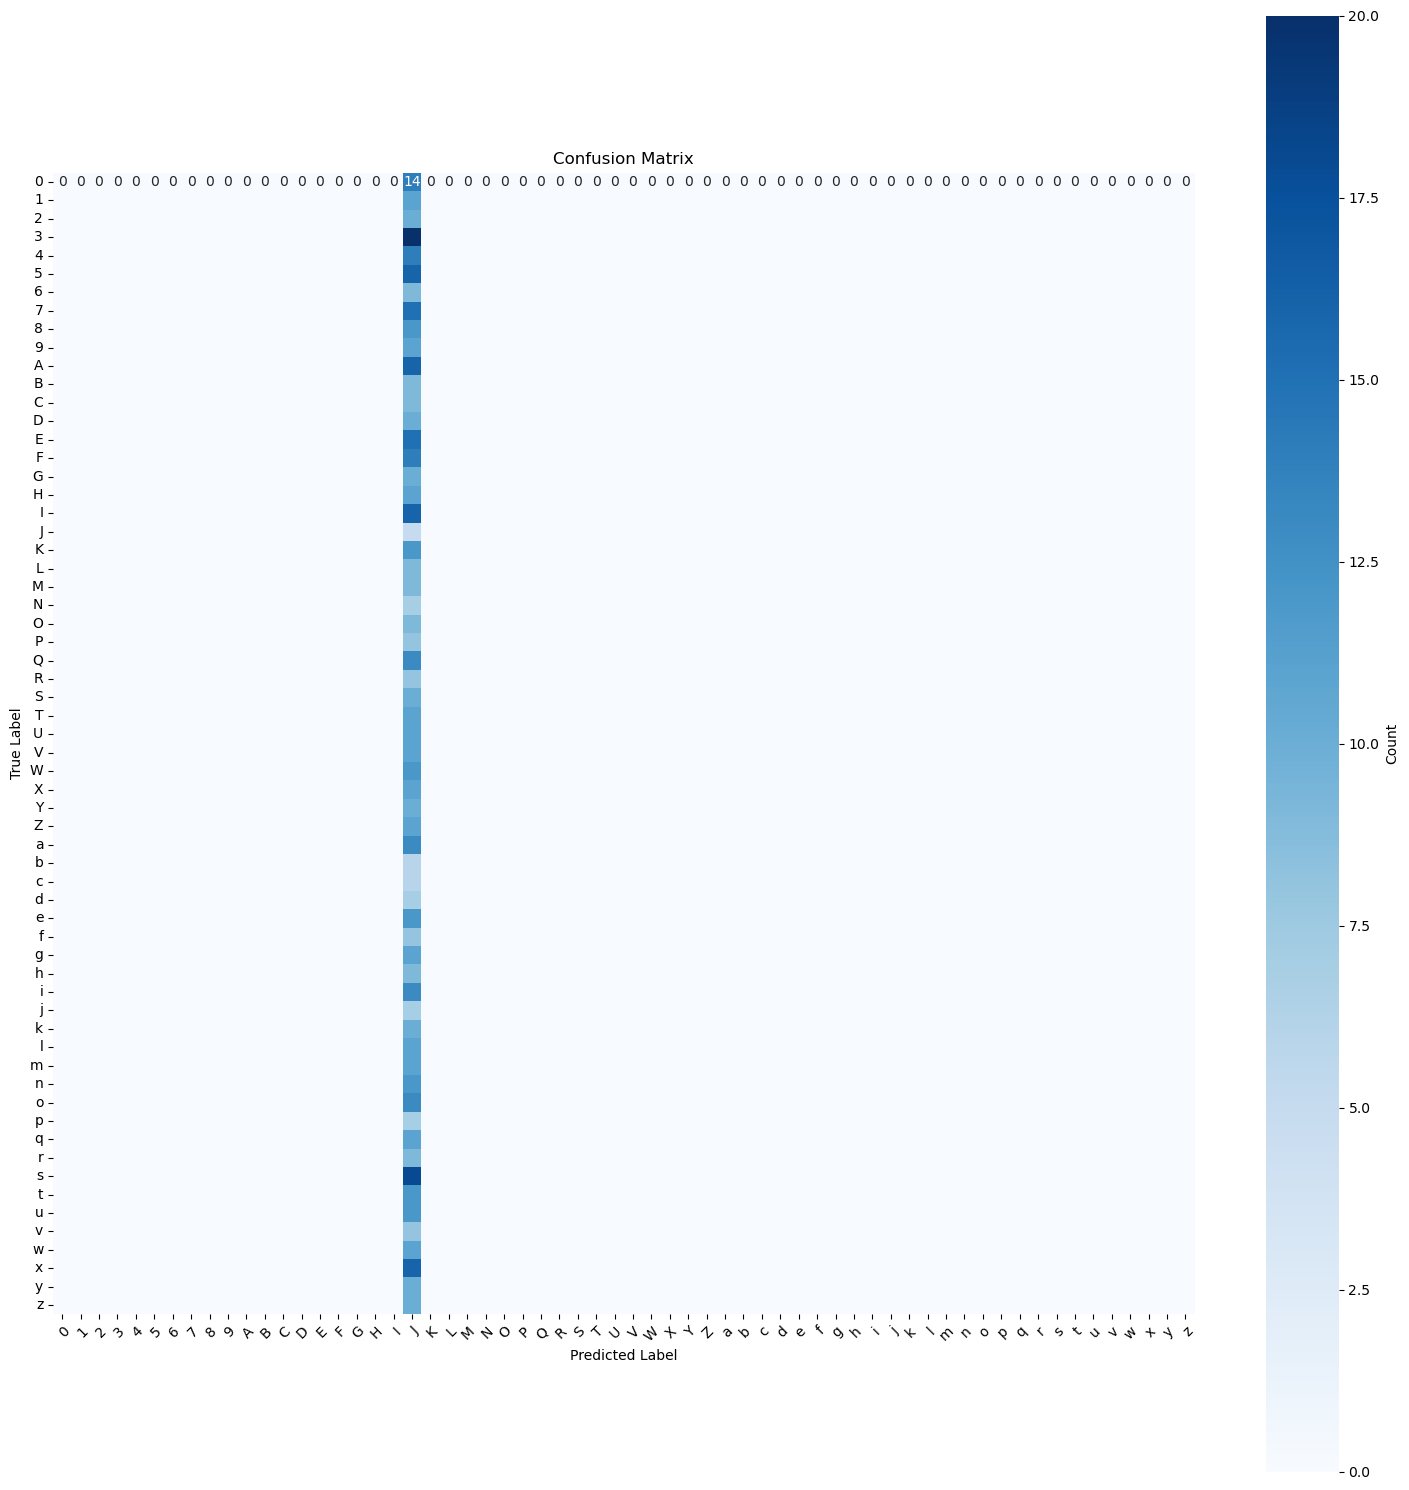

In [146]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
# Plot the loss and accuracy curves and confusion matrix
plot_loss_and_accuracy_curves(history_lstm1)
y_pred_encoded = best_model2.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [147]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm/assets


In [55]:
# Define the model with LSTM with 4 convolutional layers and L2 regularization
def build_icr_model_with_lstm2(input_shape, num_classes, dropout_rate=0.5, l2_rate=0.001):
    # Input layer
    input_img = Input(shape=input_shape, name='image_input')

    # CNN layers with L2 Regularization
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)

    # Add a Dropout layer after Convolutional layers
    x = Dropout(dropout_rate)(x)

    # Reshape output for RNN input
    conv_shape = x.get_shape().as_list()  # [batch_size, height, width, channels]
    new_shape = (conv_shape[1], conv_shape[2] * conv_shape[3])  # Combine width and channels for LSTM input
    x = Reshape(target_shape=new_shape)(x)

    # RNN layer with LSTM
    x = LSTM(128, return_sequences=False)(x)

    # Optional: Add a Dropout layer after LSTM layer
    x = Dropout(dropout_rate)(x)

    # Fully connected layer with L2 Regularization
    output = Dense(num_classes, activation='softmax', name='output', kernel_regularizer=l2(l2_rate))(x)

    # Define the model
    model = Model(inputs=input_img, outputs=output)
    
    return model

input_shape = (128, 128, 3)  # Assuming the input images are 128x128 RGB images
num_classes = 62  # Assuming 62 classes for the classification task

# Build the model with LSTM
model = build_icr_model_with_lstm2(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
# Define the early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model with LSTM
history_lstm2 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
85/85 [==============================] - 15s 168ms/step - loss: 4.3060 - accuracy: 0.0137 - val_loss: 4.2526 - val_accuracy: 0.0088 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 14s 159ms/step - loss: 4.2277 - accuracy: 0.0182 - val_loss: 4.2105 - val_accuracy: 0.0073 - lr: 0.0010
Epoch 3/100
85/85 [==============================] - 1012s 12s/step - loss: 4.1931 - accuracy: 0.0141 - val_loss: 4.1847 - val_accuracy: 0.0073 - lr: 0.0010
Epoch 4/100
85/85 [==============================] - 1953s 23s/step - loss: 4.0910 - accuracy: 0.0308 - val_loss: 3.8846 - val_accuracy: 0.0352 - lr: 0.0010
Epoch 5/100
85/85 [==============================] - 67s 800ms/step - loss: 3.6511 - accuracy: 0.0731 - val_loss: 3.3900 - val_accuracy: 0.1481 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 104s 1s/step - loss: 3.1927 - accuracy: 0.1569 - val_loss: 2.9684 - val_accuracy: 0.2287 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - 16s 193

22/22 [==============================] - 1s 41ms/step - loss: 0.7159 - accuracy: 0.8167
Test Loss: 0.7158828973770142
Test Accuracy: 81.67%


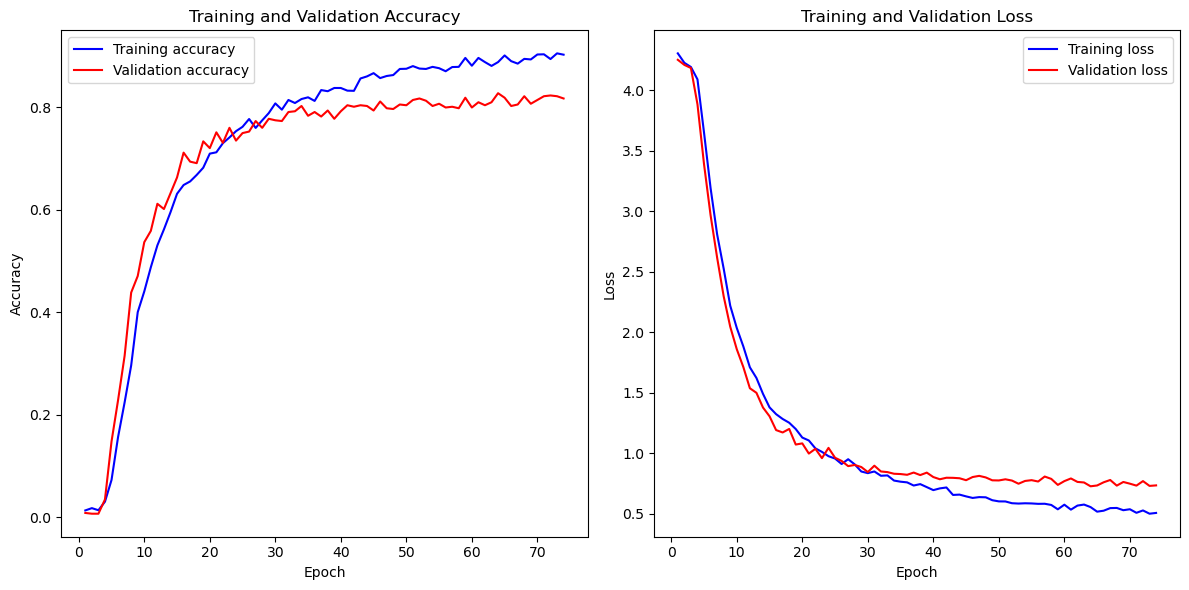

22/22 [==============================] - 2s 61ms/step
              precision    recall  f1-score   support

           0       0.58      0.50      0.54        14
           1       0.58      0.64      0.61        11
           2       0.89      0.80      0.84        10
           3       0.90      0.95      0.93        20
           4       0.75      0.86      0.80        14
           5       1.00      0.88      0.93        16
           6       0.90      1.00      0.95         9
           7       1.00      0.87      0.93        15
           8       0.79      0.92      0.85        12
           9       0.92      1.00      0.96        11
           A       1.00      0.88      0.93        16
           B       1.00      0.89      0.94         9
           C       0.73      0.89      0.80         9
           D       1.00      0.90      0.95        10
           E       1.00      1.00      1.00        15
           F       1.00      0.93      0.96        14
           G       1.00    

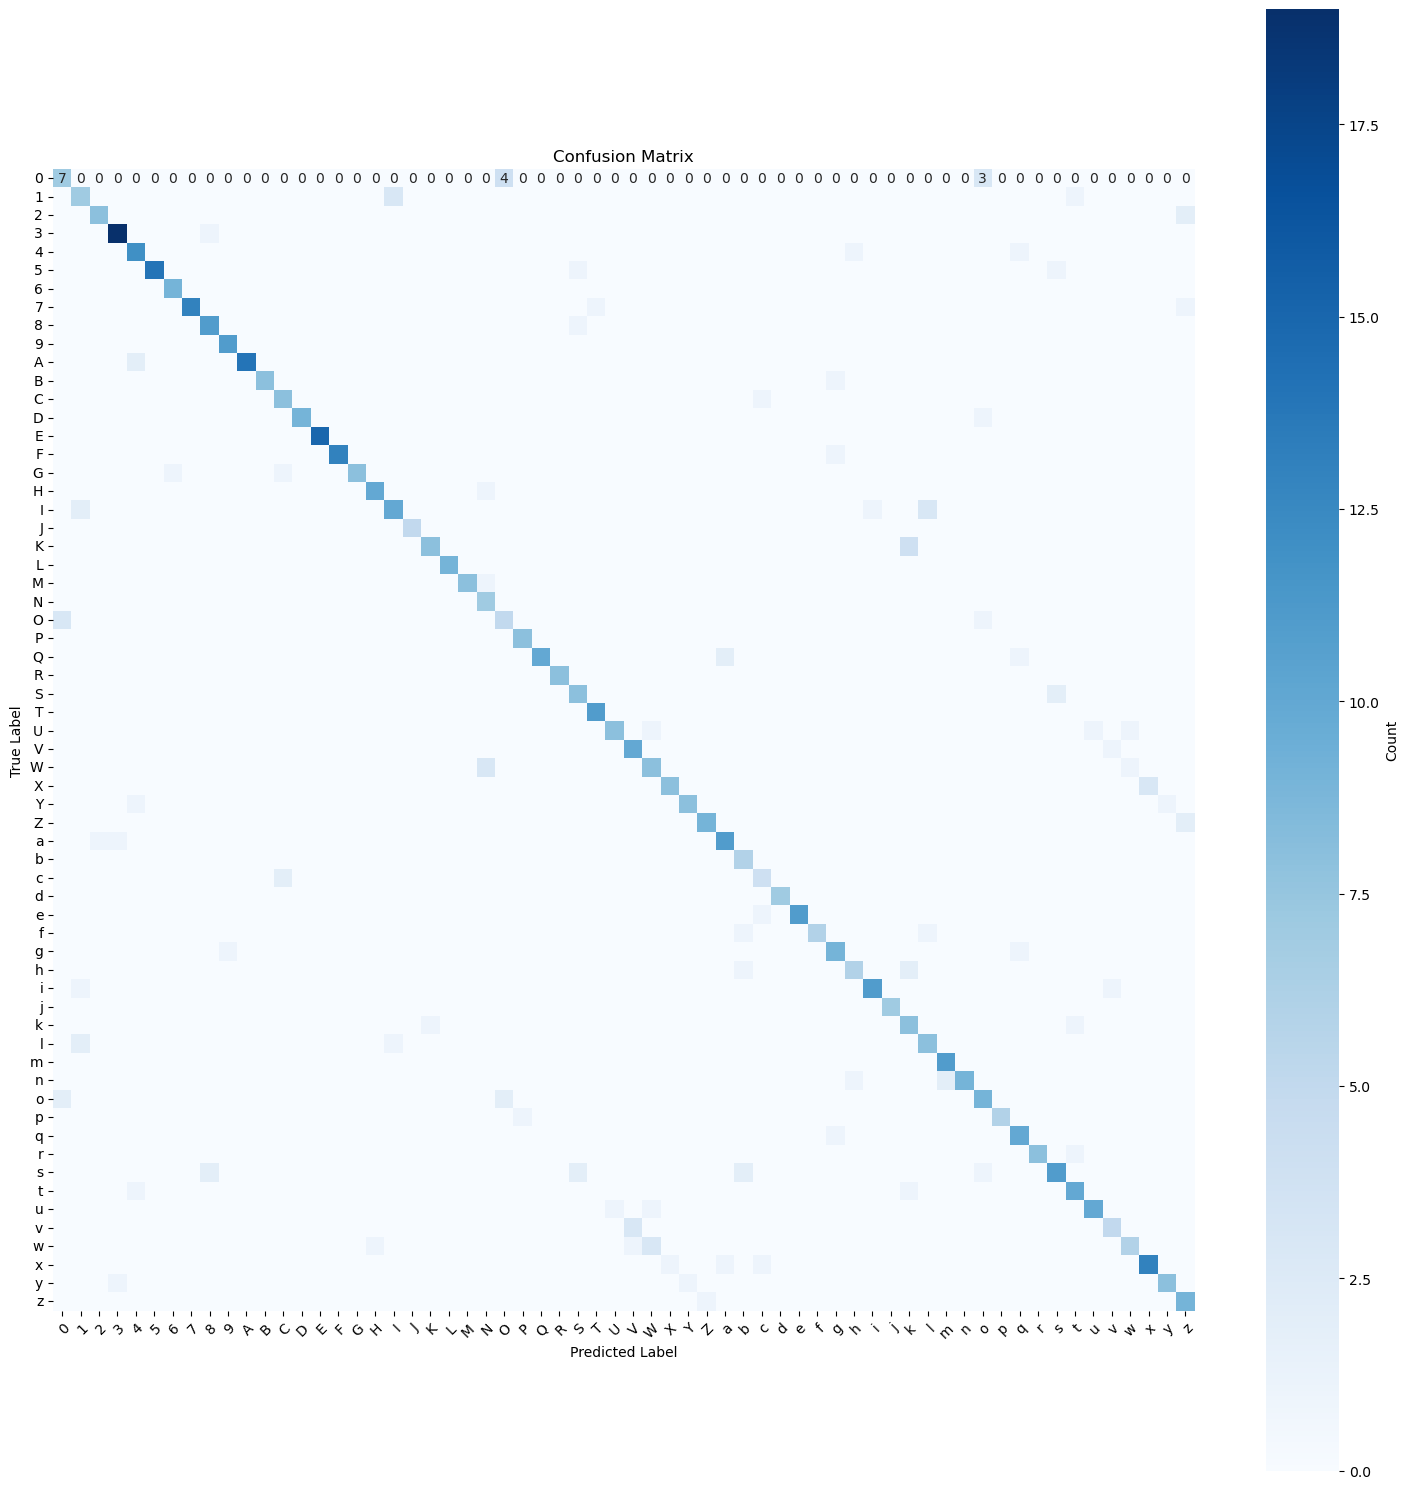

In [57]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
# Plot the loss and accuracy curves and confusion matrix
plot_loss_and_accuracy_curves(history_lstm2)
y_pred_encoded = model.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [58]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm2')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm2/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm2/assets


In [152]:
# Define the model with LSTM with 5 convolutional layers and L2 regularization
def build_icr_model_with_lstm3(input_shape, num_classes, dropout_rate=0.5, l2_rate=0.001):
    input_img = Input(shape=input_shape, name='image_input')

    # CNN layers with L2 Regularization
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_rate))(x)
    x = MaxPooling2D((2, 2))(x)

    # Add a Dropout layer after Convolutional layers
    x = Dropout(dropout_rate)(x)

    # Reshape output for RNN input
    conv_shape = x.get_shape().as_list()  # [batch_size, height, width, channels]
    new_shape = (conv_shape[1], conv_shape[2] * conv_shape[3])  # Combine width and channels for LSTM input
    x = Reshape(target_shape=new_shape)(x)

    # RNN layer with LSTM
    x = LSTM(128, return_sequences=False)(x)

    # Optional: Add a Dropout layer after LSTM layer
    x = Dropout(dropout_rate)(x)

    # Fully connected layer with L2 Regularization
    output = Dense(num_classes, activation='softmax', name='output', kernel_regularizer=l2(l2_rate))(x)

    # Define the model
    model = Model(inputs=input_img, outputs=output)
    
    return model

input_shape = (128, 128, 3)  # the input images are 128x128 RGB images
num_classes = 62  # 62 classes for the classification task

# Build the model with LSTM
model = build_icr_model_with_lstm2(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [153]:
# Define the early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model with LSTM
history_lstm3 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
85/85 [==============================] - 17s 189ms/step - loss: 4.3148 - accuracy: 0.0134 - val_loss: 4.2648 - val_accuracy: 0.0117 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 16s 189ms/step - loss: 4.2396 - accuracy: 0.0141 - val_loss: 4.2222 - val_accuracy: 0.0103 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 16s 189ms/step - loss: 4.2036 - accuracy: 0.0193 - val_loss: 4.1947 - val_accuracy: 0.0103 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 16s 183ms/step - loss: 4.0724 - accuracy: 0.0338 - val_loss: 3.8694 - val_accuracy: 0.0396 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 16s 186ms/step - loss: 3.6247 - accuracy: 0.0920 - val_loss: 3.3901 - val_accuracy: 0.1232 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 16s 188ms/step - loss: 3.2156 - accuracy: 0.1517 - val_loss: 3.0638 - val_accuracy: 0.1848 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 16s 192ms/st

22/22 [==============================] - 1s 46ms/step - loss: 0.7853 - accuracy: 0.8109
Test Loss: 0.7852836847305298
Test Accuracy: 81.09%


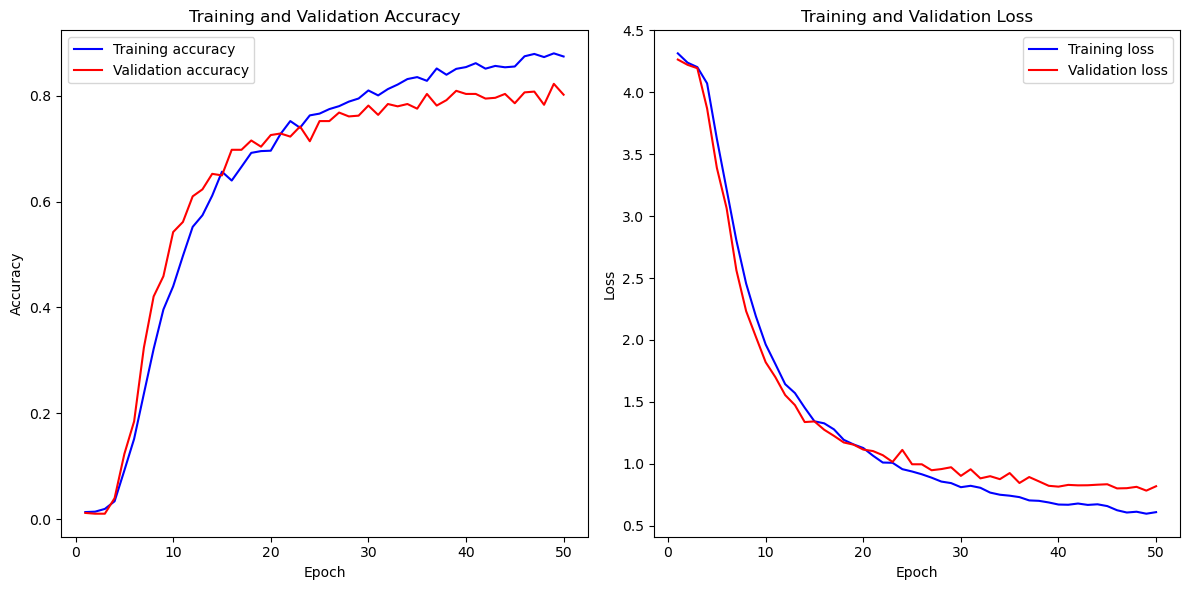

22/22 [==============================] - 2s 67ms/step
              precision    recall  f1-score   support

           0       0.67      0.14      0.24        14
           1       0.50      0.73      0.59        11
           2       0.80      0.80      0.80        10
           3       0.83      0.95      0.88        20
           4       1.00      0.79      0.88        14
           5       1.00      1.00      1.00        16
           6       0.75      1.00      0.86         9
           7       1.00      0.87      0.93        15
           8       0.53      0.83      0.65        12
           9       0.64      0.82      0.72        11
           A       0.93      0.88      0.90        16
           B       1.00      0.89      0.94         9
           C       0.82      1.00      0.90         9
           D       1.00      1.00      1.00        10
           E       0.94      1.00      0.97        15
           F       1.00      0.93      0.96        14
           G       1.00    

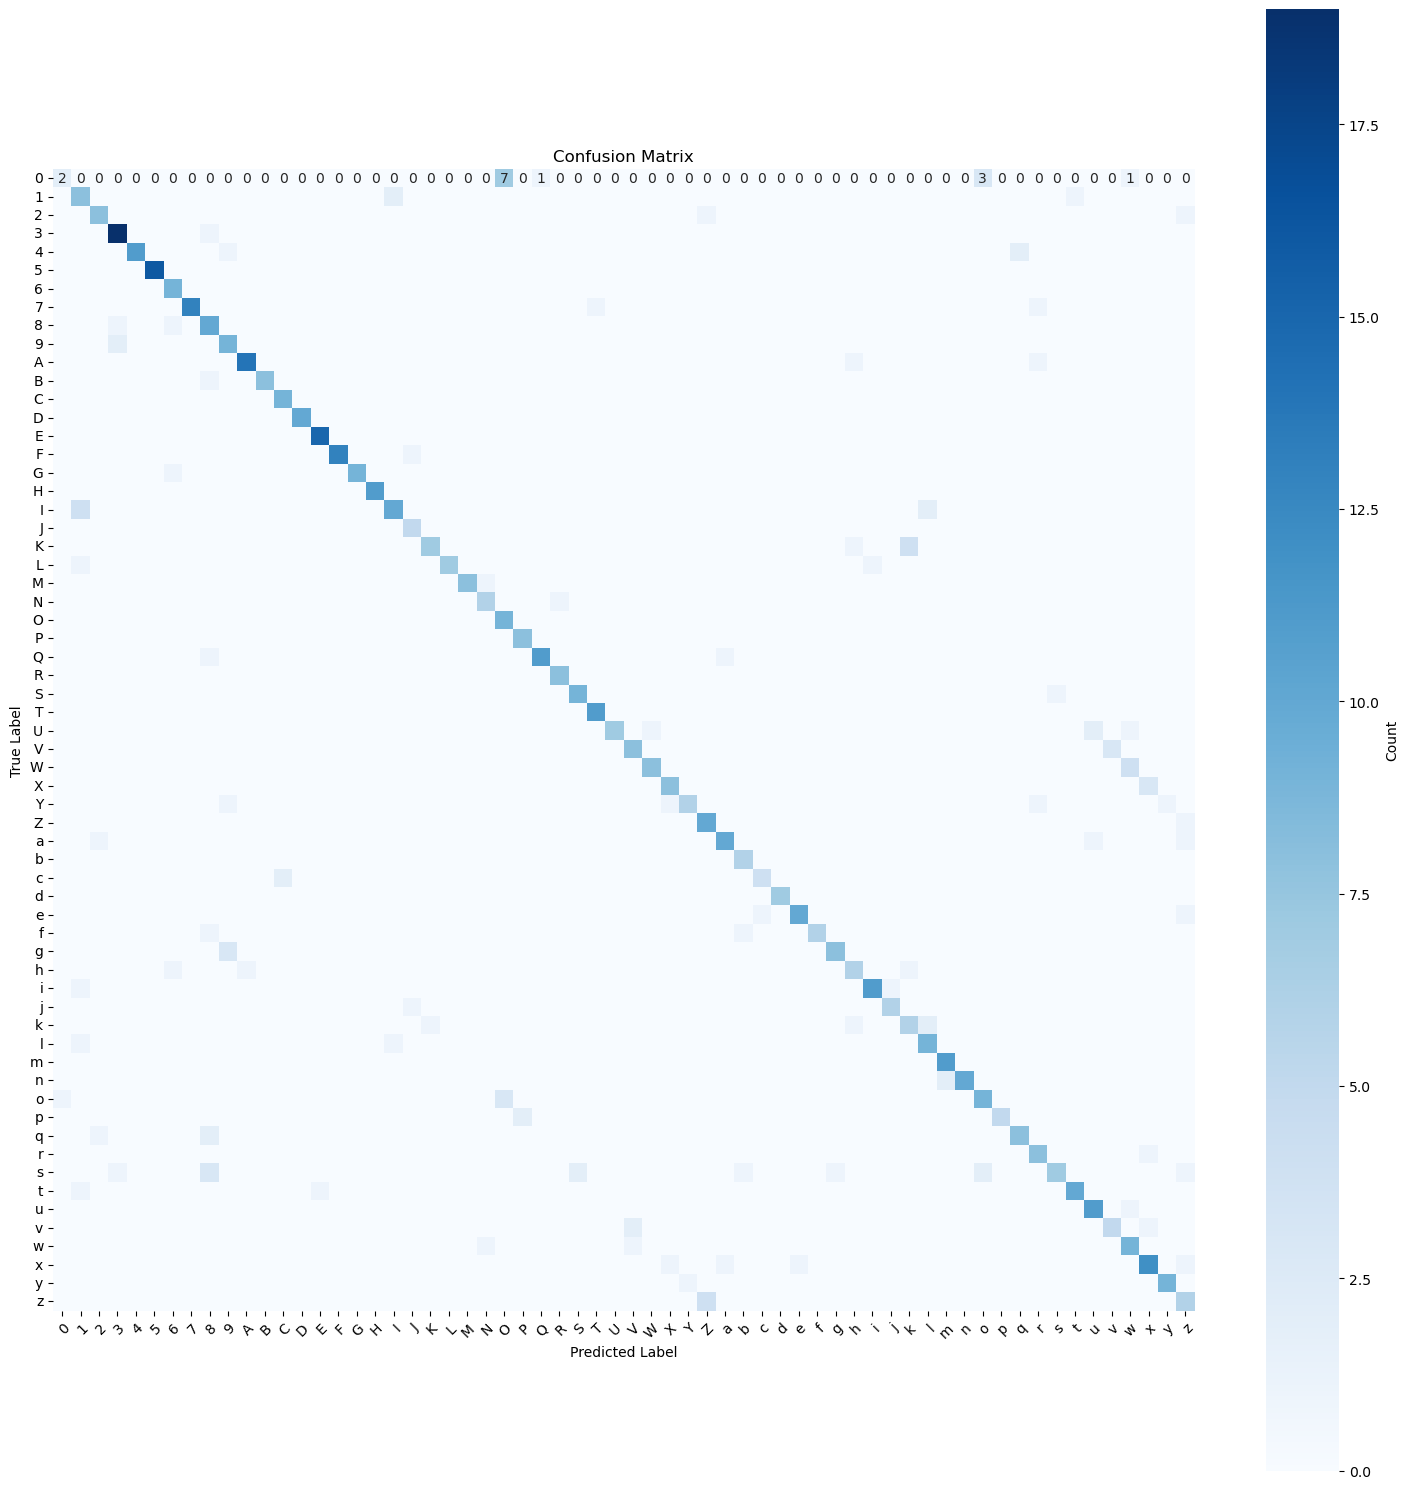

In [154]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
# Plot the loss and accuracy curves and confusion matrix
plot_loss_and_accuracy_curves(history_lstm3)
y_pred_encoded = model.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [155]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm3_50epochs')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm3_50epochs/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm3_50epochs/assets


LSTM3 with 100 training epochs

In [158]:
# Define early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model with 100 epochs
history_lstm4 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
85/85 [==============================] - 16s 187ms/step - loss: 0.5880 - accuracy: 0.8828 - val_loss: 0.8242 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 16s 191ms/step - loss: 0.5823 - accuracy: 0.8835 - val_loss: 0.8021 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 3/100
85/85 [==============================] - 16s 184ms/step - loss: 0.5614 - accuracy: 0.8839 - val_loss: 0.7764 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 4/100
85/85 [==============================] - 15s 173ms/step - loss: 0.5844 - accuracy: 0.8817 - val_loss: 0.8051 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 5/100
85/85 [==============================] - 15s 173ms/step - loss: 0.5683 - accuracy: 0.8850 - val_loss: 0.8402 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 15s 171ms/step - loss: 0.5502 - accuracy: 0.8880 - val_loss: 0.7766 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - 15s 1

22/22 [==============================] - 1s 39ms/step - loss: 0.7288 - accuracy: 0.8299
Test Loss: 0.728795051574707
Test Accuracy: 82.99%


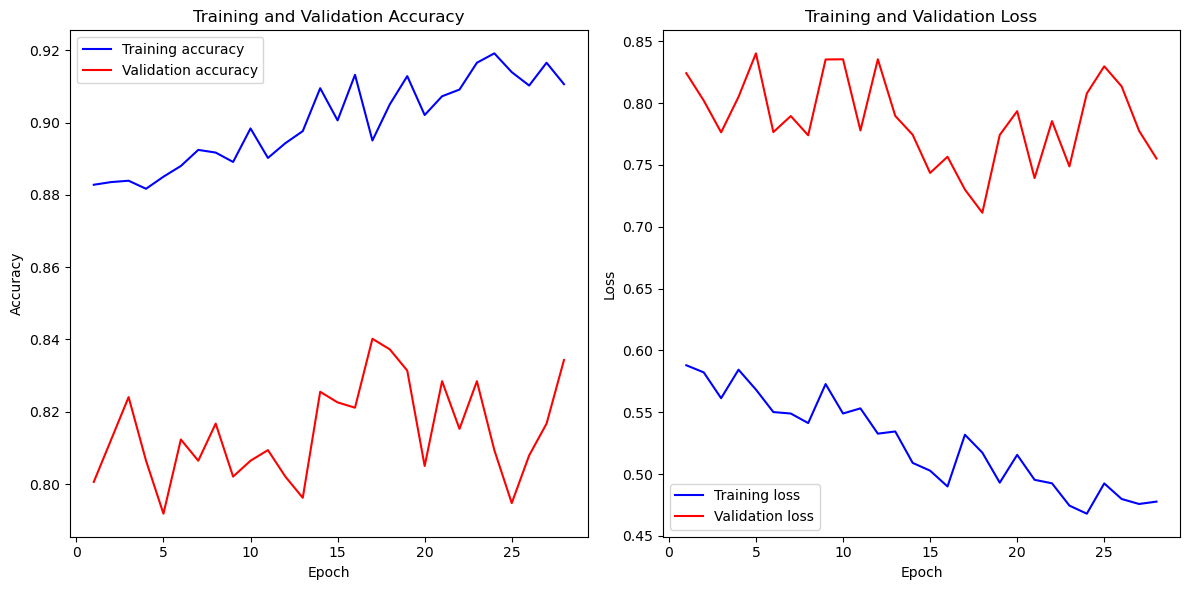

22/22 [==============================] - 1s 63ms/step
              precision    recall  f1-score   support

           0       0.88      0.50      0.64        14
           1       0.56      0.91      0.69        11
           2       1.00      0.80      0.89        10
           3       0.90      0.95      0.93        20
           4       0.92      0.86      0.89        14
           5       1.00      0.94      0.97        16
           6       0.89      0.89      0.89         9
           7       1.00      0.93      0.97        15
           8       0.59      0.83      0.69        12
           9       0.91      0.91      0.91        11
           A       0.94      0.94      0.94        16
           B       1.00      0.78      0.88         9
           C       0.73      0.89      0.80         9
           D       1.00      1.00      1.00        10
           E       0.94      1.00      0.97        15
           F       1.00      0.93      0.96        14
           G       0.91    

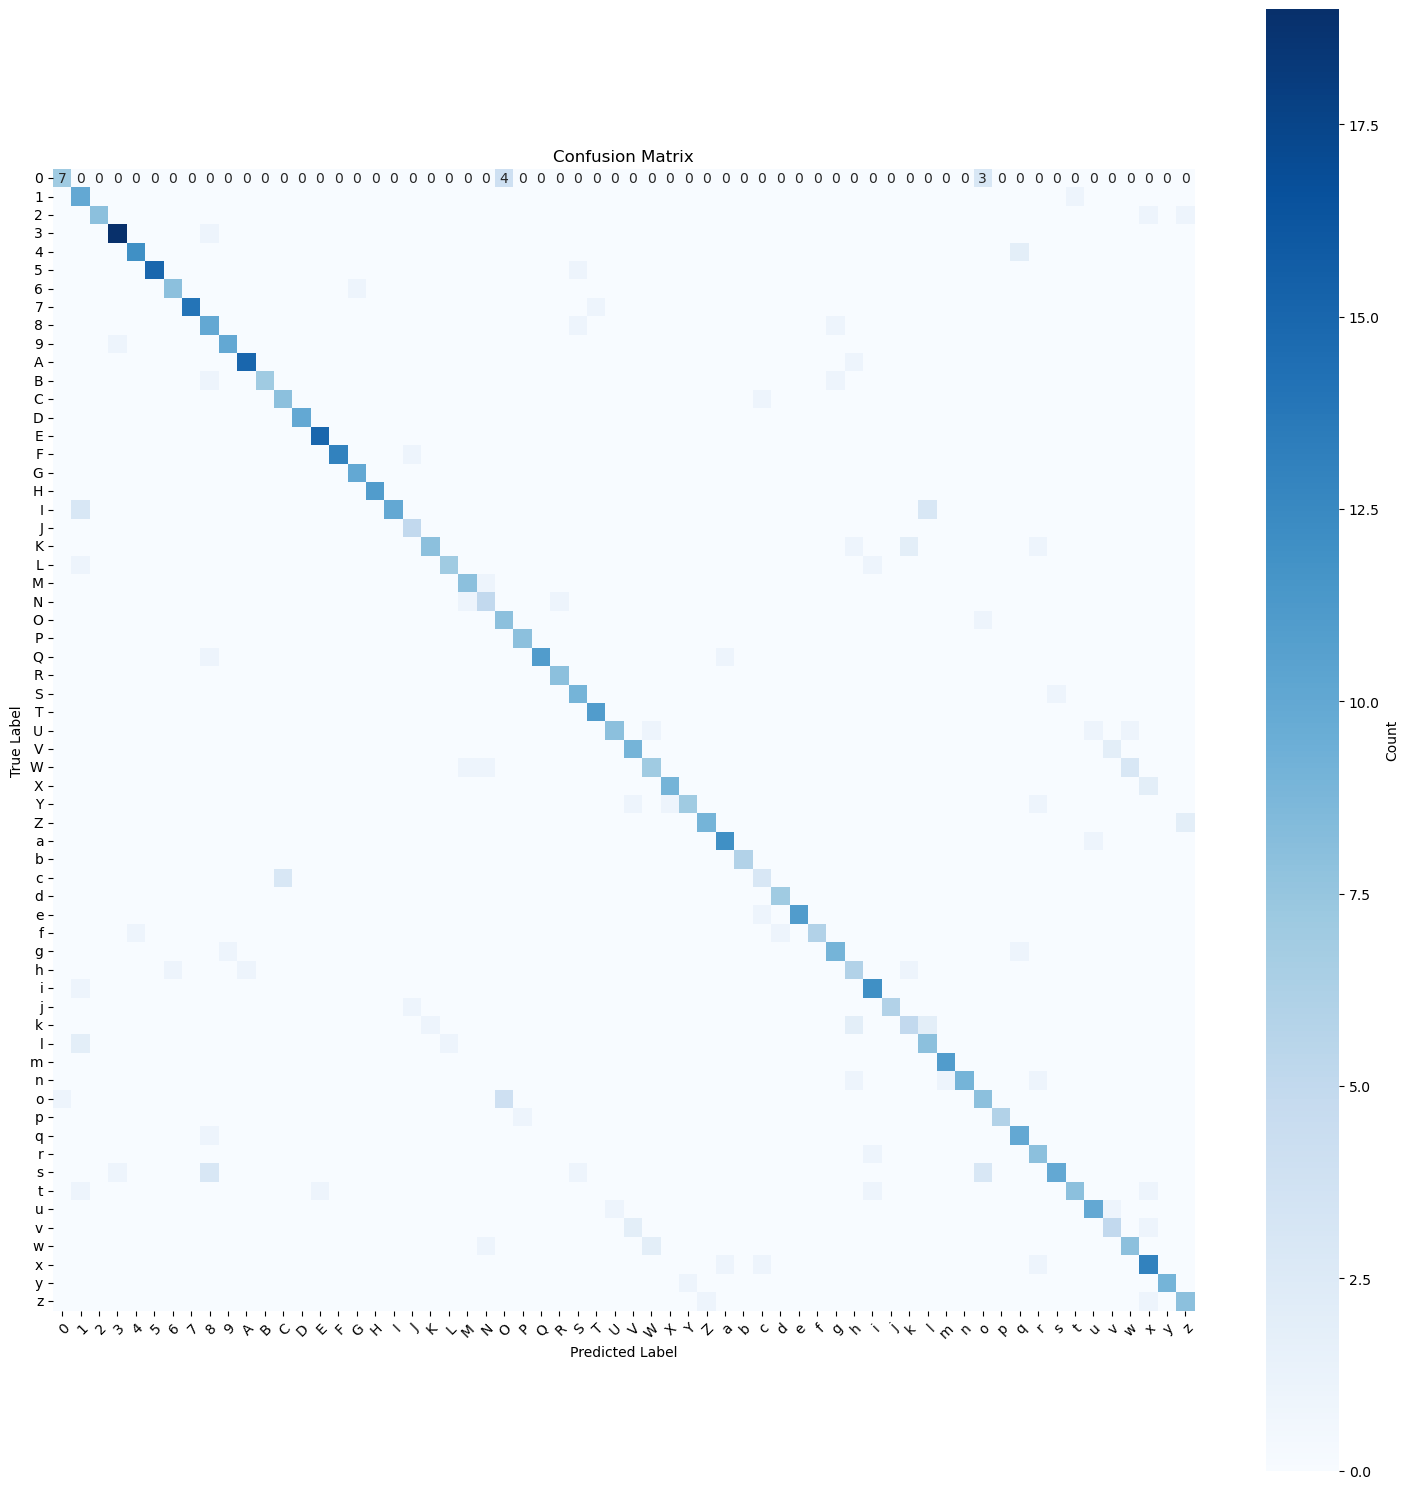

In [159]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
# Plot the loss and accuracy curves and confusion matrix
plot_loss_and_accuracy_curves(history_lstm4)
y_pred_encoded = model.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [160]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm3_100epochs')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm3_100epochs/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_cnn_lstm3_100epochs/assets


Apply median filter to the dataset to enhance model

In [19]:
# Definr the function to apply the median filter to the image
def apply_median_filter(image):
    filtered_image = median_filter(image, size=3)
    return filtered_image
# Apply the median filter to the training and test sets
train_generator_median_filter = ImageDataGenerator(preprocessing_function=apply_median_filter).flow(X_train, y_train_encoded)
test_generator_median_filter = ImageDataGenerator(preprocessing_function=apply_median_filter).flow(X_test, y_test_encoded)

In [192]:
# Load the existing model
model_directory = '/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_hyper_with_regu'
# Load the model
loaded_model = tf.keras.models.load_model(model_directory)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model with the median filter
history = loaded_model.fit(
    train_generator_median_filter,
    steps_per_epoch=len(X_train) // 32,
    epochs=1000,
    validation_data=test_generator_median_filter,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/1000
85/85 [==============================] - 25s 277ms/step - loss: 0.4736 - accuracy: 0.9143 - val_loss: 0.7293 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 2/1000
85/85 [==============================] - 26s 303ms/step - loss: 0.4486 - accuracy: 0.9236 - val_loss: 0.7346 - val_accuracy: 0.8372 - lr: 0.0010
Epoch 3/1000
85/85 [==============================] - 25s 293ms/step - loss: 0.4396 - accuracy: 0.9258 - val_loss: 0.7353 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 4/1000
85/85 [==============================] - 23s 265ms/step - loss: 0.4682 - accuracy: 0.9102 - val_loss: 0.8304 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 5/1000
85/85 [==============================] - 23s 269ms/step - loss: 0.4469 - accuracy: 0.9251 - val_loss: 0.7574 - val_accuracy: 0.8226 - lr: 0.0010
Epoch 6/1000
85/85 [==============================] - 23s 273ms/step - loss: 0.4465 - accuracy: 0.9225 - val_loss: 0.7709 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 7/1000
85/85 [==============================] 

In [193]:
# Evaluate the model on the test data
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

22/22 [==============================] - 2s 82ms/step - loss: 0.7253 - accuracy: 0.8402
Test Loss: 0.7253147959709167
Test Accuracy: 84.02%


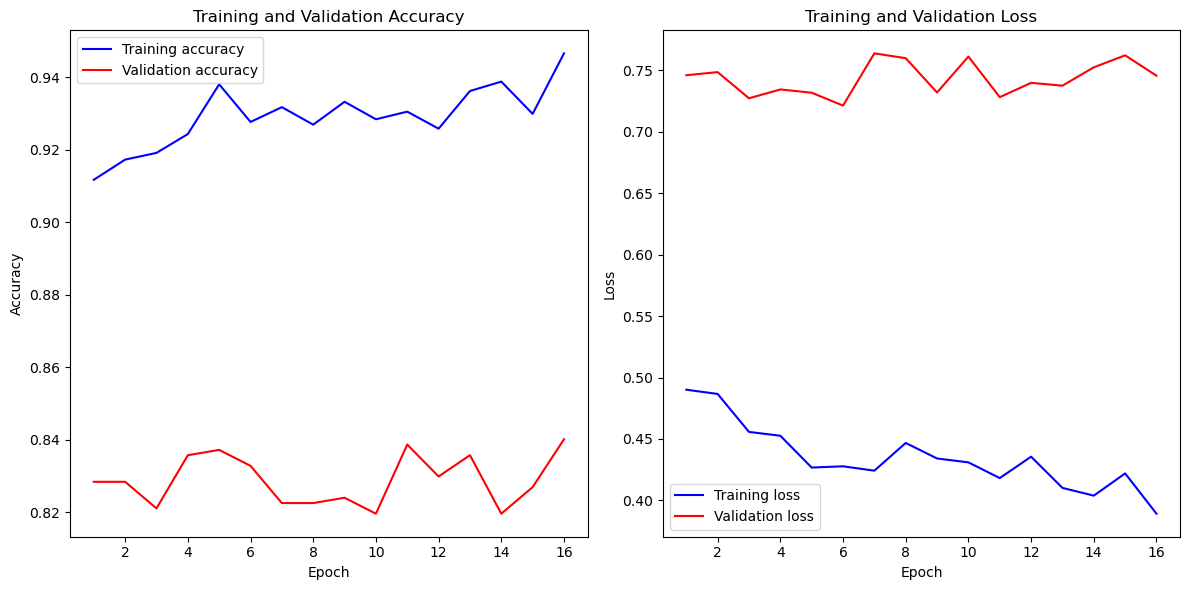

22/22 [==============================] - 2s 89ms/step
              precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.75      0.82      0.78        11
           2       0.82      0.90      0.86        10
           3       0.83      1.00      0.91        20
           4       0.92      0.86      0.89        14
           5       0.89      1.00      0.94        16
           6       0.90      1.00      0.95         9
           7       1.00      0.93      0.97        15
           8       0.71      0.83      0.77        12
           9       0.82      0.82      0.82        11
           A       0.94      0.94      0.94        16
           B       1.00      0.89      0.94         9
           C       0.73      0.89      0.80         9
           D       1.00      1.00      1.00        10
           E       0.94      1.00      0.97        15
           F       0.93      0.93      0.93        14
           G       0.90    

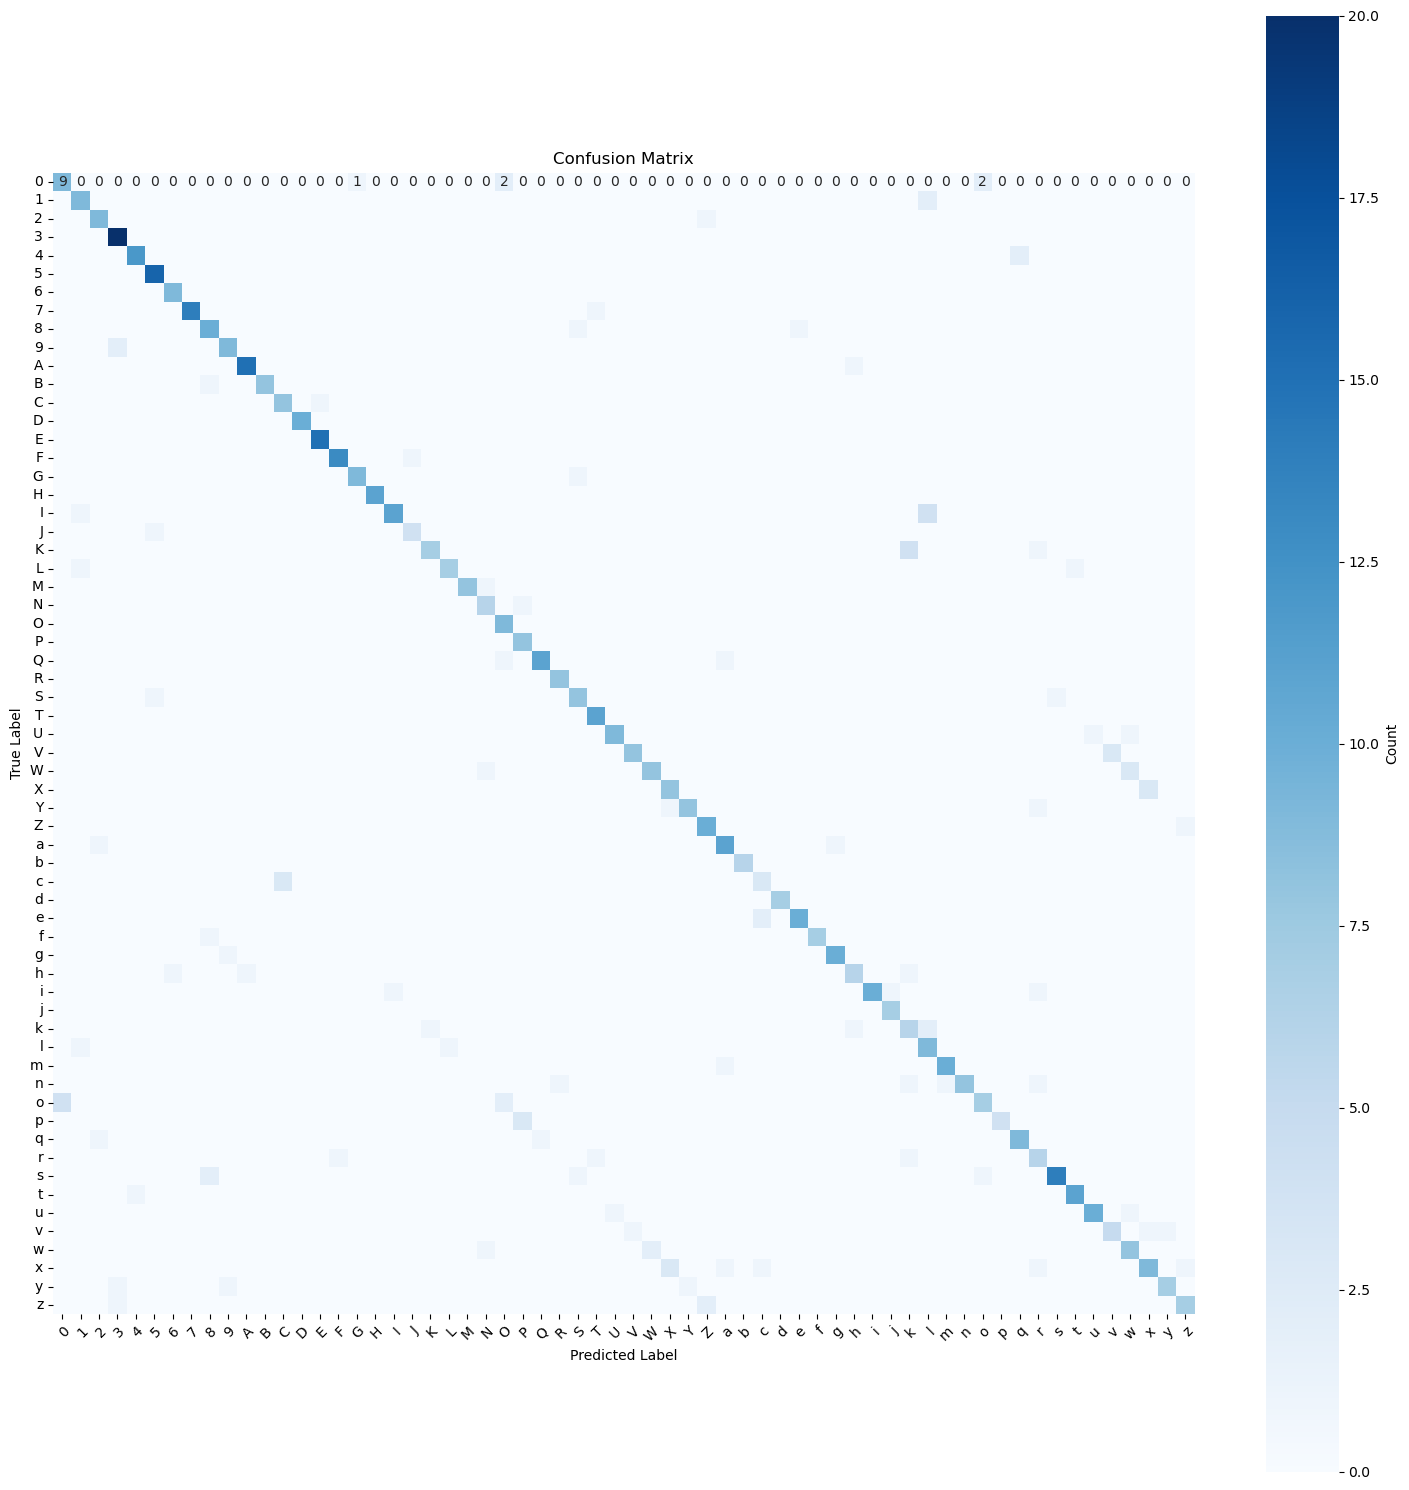

In [227]:
plot_loss_and_accuracy_curves(history)
y_pred_encoded = model.predict(test_generator)
plot_confusion_matrix_and_report(y_test_encoded, np.argmax(y_pred_encoded, axis=1), label_encoder)

In [228]:
loaded_model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/english_hyper_with_regu_median_filter')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_hyper_with_regu_median_filter/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/english_hyper_with_regu_median_filter/assets


In [229]:
# Model summary
loaded_model.build(input_shape=(None, *input_shape))
print(loaded_model.summary())

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_94 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_95 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_95 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_96 (Conv2D)          (None, 32, 32, 64)        369